# Taxi trips count prediction

The task is to create a model that predicts the count of taxi trips for the next hour in [Chicago's community areas](https://en.wikipedia.org/wiki/Community_areas_in_Chicago).  
  
Links to the datasets:  
https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz  
https://data.cityofchicago.org/Transportation/Taxi-Trips-2023/e55j-2ewb

## Load libraries and data

In [1]:
import re
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import date_format, col, count, countDistinct, date_trunc, isnull, lag
from pyspark.sql.functions import max as spark_max
from pyspark.sql.functions import median, mode
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import to_timestamp, when
from pyspark.sql.window import Window
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm

from lib.time_series_processing import TSDataManager

In [2]:
!pip install -q catboost
from catboost import CatBoostRegressor

In [3]:
!pip install -q lightgbm==3.3.5
import lightgbm as lgb

In [302]:
plt.style.use("fivethirtyeight")
plt_params = {
    "axes.titlesize": "18",
    "axes.labelsize": "15",
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "xtick.labelsize": "13",
    "ytick.labelsize": "13",
    "legend.fontsize": "13",
    "lines.linewidth": "2.0",
}

plt.rcParams.update(plt_params)

In [5]:
warnings.simplefilter("ignore")

In [6]:
# reload modules before execution

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np

np.random.seed(42)

In [9]:
APP_NAME = "taxi"
SPARK_MASTER_IP = "172.18.0.2"

PAYMENT_TYPE_THRESHOLD = 1000
TAXI_COMPANY_THRESHOLD = 100
TEST_SIZE = 0.15
START_DATE = "2022-01-08"  # we use trips count with 1 week lag

In [10]:
spark = (
    SparkSession.builder.appName(APP_NAME)
    .config("spark.sql.repl.eagerEval.enabled", True)
    .master(f"spark://{SPARK_MASTER_IP}:7077")
    .config("spark.executor.cores", 2)
    .config("spark.task.cpus", 2)
    .config("spark.executor.memory", "3g")
    .getOrCreate()
)

In [274]:
taxi_2022 = spark.read.load("data/trips_2022.csv", format="csv", header="true", inferSchema="true")

In [275]:
taxi_2023 = spark.read.load("data/trips_2023.csv", format="csv", header="true", inferSchema="true")

## Data cleaning

First step is to remove illogical and erroneous values in data, as well as to delete redundant columns.

In [276]:
taxi_2022.columns

['Trip ID',
 'Taxi ID',
 'Trip Start Timestamp',
 'Trip End Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Census Tract',
 'Dropoff Census Tract',
 'Pickup Community Area',
 'Dropoff Community Area',
 'Fare',
 'Tips',
 'Tolls',
 'Extras',
 'Trip Total',
 'Payment Type',
 'Company',
 'Pickup Centroid Latitude',
 'Pickup Centroid Longitude',
 'Pickup Centroid Location',
 'Dropoff Centroid Latitude',
 'Dropoff Centroid Longitude',
 'Dropoff Centroid  Location']

Converting the trip data to datetime format and removing excessive trips:

In [277]:
taxi_2022 = taxi_2022.withColumn("Trip Start Timestamp", to_timestamp(col("Trip Start Timestamp"), "M/d/yyyy h:m:s a"))

taxi_2022 = taxi_2022.filter(date_format(col("Trip Start Timestamp"), "yyyy-MM-dd") < "2023-01-01")

In [278]:
taxi_2023 = taxi_2023.withColumn("Trip Start Timestamp", to_timestamp(col("Trip Start Timestamp"), "M/d/yyyy h:m:s a"))

taxi_2023 = taxi_2023.filter(date_format(col("Trip Start Timestamp"), "yyyy-MM-dd") < "2023-08-01")

Joining data for 2022/2023 and removing columns with useless information:

In [279]:
taxi = taxi_2022.union(taxi_2023)

In [280]:
taxi = taxi.drop(*["Pickup Centroid Location", "Dropoff Centroid  Location", "Trip ID", "Trip End Timestamp"])

### Money features

Remove rows where total cost of trip differs significantly from the sum of payments:

In [281]:
# taxi.filter(taxi['Trip Total'] - (taxi['Fare'] + taxi['Tips'] + taxi['Tolls'] + taxi['Extras']) > 3).count()
# 412

In [282]:
taxi = taxi.filter(taxi["Trip Total"] - (taxi["Fare"] + taxi["Tips"] + taxi["Tolls"] + taxi["Extras"]) < 3)

### Time and distance features

Add a new feature (**Mean Speed**). Remove entries where mean speed is more than 70 mph, as this is the speed limit in Chicago and its proximity.

In [283]:
taxi = taxi.withColumn("Mean Speed", col("Trip Miles") / (col("Trip Seconds") / 3600))

In [284]:
# taxi.filter(col("Mean Speed") > 70).count()
# 12359

In [285]:
taxi = taxi.filter(col("Mean Speed") <= 70)

### Categorial features

Remove rows with rare company or payment type.

In [286]:
# taxi.agg(countDistinct(col('Taxi ID')))

In [287]:
# taxi.agg(countDistinct(col('Company')))

In [288]:
company_counts = taxi.groupBy("Company").count()
filtered_companies = company_counts.filter(company_counts["count"] < TAXI_COMPANY_THRESHOLD)
companies_to_drop = filtered_companies.select("Company")

In [289]:
taxi = taxi.join(companies_to_drop, on="Company", how="left_anti")

In [290]:
payment_type_counts = taxi.groupBy("Payment Type").count()
filtered_payment_types = payment_type_counts.filter(payment_type_counts["count"] < PAYMENT_TYPE_THRESHOLD)
payment_types_to_drop = filtered_payment_types.select("Payment Type")

In [291]:
taxi = taxi.join(payment_types_to_drop, on="Payment Type", how="left_anti")

## Data processing

In order to predict values for the next hour in a given community area, the data needs to be properly transformed.  
First, the gaps will be filled, then the following transformations will be performed for the dataset features:

* [x] `Latitudes / Longitudes`: drop
* [x] `Taxi ID`: unique taxi ids for the current hour and current community area  
* [x] `Pickup / Dropoff census tract`: unique count
* [x] `Trip seconds`: aggregate, median  
* [x] `Trip miles`: aggregate, median  
* [x] `Money factors`: aggregate, median  
* [x] `Census tracts`: mode
* [x] `Payment type / Company`: frequency of values within an hour

Feature engineering:  
* [x] Trips count, trip total rolling mean and lags
* [x] Time features (dow, hour)

### Gaps

For missing community areas, use the value 100:

In [292]:
taxi = taxi.fillna(100, subset=["Pickup Community Area"])
taxi = taxi.fillna(100, subset=["Dropoff Community Area"])

Before imputation, save geo features for 2023 for further investigation.

In [293]:
geo_features_pickup = taxi.filter(date_format(col("Trip Start Timestamp"), "yyyy-MM-dd") >= "2023-01-01").select(
    "Pickup Community Area",
    "Pickup Census Tract",
    "Pickup Centroid Latitude",
    "Pickup Centroid Longitude",
)

In [29]:
MULTIPLIER = 1.001

In [30]:
# taxi.select([count(when(isnull(c), c)).alias(c) for c in taxi.columns])

For missing latitude / longitude / census tract, use the max value in the feature column, multiplied by 1.001:

In [32]:
max_values = taxi.select(
    spark_max(col("Pickup Centroid Latitude")).alias("max_pc_lat"),
    spark_max(col("Pickup Centroid Longitude")).alias("max_pc_lon"),
    spark_max(col("Dropoff Centroid Latitude")).alias("max_dc_lat"),
    spark_max(col("Dropoff Centroid Longitude")).alias("max_dc_lon"),
    spark_max(col("Pickup Census Tract")).alias("max_pcm"),
    spark_max(col("Dropoff Census Tract")).alias("max_dcm"),
).first()

In [33]:
max_pc_lat = max_values["max_pc_lat"] * MULTIPLIER
max_pc_lon = max_values["max_pc_lon"] * MULTIPLIER
max_dc_lat = max_values["max_dc_lat"] * MULTIPLIER
max_dc_lon = max_values["max_dc_lon"] * MULTIPLIER

max_pcm = round(max_values["max_pcm"] * MULTIPLIER)
max_dcm = round(max_values["max_dcm"] * MULTIPLIER)

In [34]:
taxi = taxi.fillna(max_pc_lat, subset=["Pickup Centroid Latitude"])
taxi = taxi.fillna(max_pc_lon, subset=["Pickup Centroid Longitude"])
taxi = taxi.fillna(max_dc_lat, subset=["Dropoff Centroid Latitude"])
taxi = taxi.fillna(max_dc_lon, subset=["Dropoff Centroid Longitude"])

taxi = taxi.fillna(max(max_pcm, max_dcm), subset=["Pickup Census Tract", "Dropoff Census Tract"])

For money features, impute the missing values with median value in column.

In [35]:
from pyspark.ml.feature import Imputer

columns_to_fill = [
    "Fare",
    "Tips",
    "Tolls",
    "Extras",
    "Trip Total",
]

imputer = Imputer(inputCols=columns_to_fill, outputCols=[col for col in columns_to_fill]).setStrategy("median")

taxi = imputer.fit(taxi).transform(taxi)

### Aggregating non-time features

Group by hour and location, then create unique, aggregate, median, mode and frequency features.

In [36]:
grouped = taxi.groupBy(
    date_trunc("hour", col("Trip Start Timestamp")).alias("date"), col("Pickup Community Area").alias("location")
)

#### Data transformation

##### distinct

In [37]:
agg_1_distinct = grouped.agg(
    countDistinct(col("Taxi ID")).alias("taxi_id_count_unique"),
    countDistinct(col("Pickup Census Tract")).alias("pickup_census_count_unique"),
    countDistinct(col("Dropoff Census Tract")).alias("dropoff_census_count_unique"),
)

##### sum and median

In [38]:
agg_2_sum_and_median = grouped.agg(
    spark_sum(col("Trip Seconds")).alias("trip_seconds_agg"),
    median(col("Trip Seconds")).alias("trip_seconds_median"),
    spark_sum(col("Trip Miles")).alias("trip_miles_agg"),
    median(col("Trip Miles")).alias("trip_miles_median"),
    spark_sum(col("Tips")).alias("tips_agg"),
    median(col("Tips")).alias("tips_median"),
    spark_sum(col("Fare")).alias("fare_agg"),
    median(col("Fare")).alias("fare_median"),
    spark_sum(col("Tolls")).alias("tolls_agg"),
    median(col("Tolls")).alias("tolls_median"),
    spark_sum(col("Extras")).alias("extras_agg"),
    median(col("Extras")).alias("extras_median"),
    spark_sum(col("Trip Total")).alias("trip_total_agg"),
    median(col("Trip Total")).alias("trip_total_median"),
    median(col("Mean Speed")).alias("mean_speed_median"),
)

##### mode

In [39]:
agg_3_mode = grouped.agg(
    mode(col("Pickup Census Tract")).alias("pickup_census_mode"),
    mode(col("Dropoff Census Tract")).alias("dropoff_census_mode"),
)

##### frequency

In [40]:
companies = company_counts.select("Company").collect()
payment_types = payment_type_counts.select("Payment Type").collect()

In [41]:
# this code calculates frequencies of occurrence of every unique company
company_frequencies = grouped.agg(
    *[
        (
            spark_sum((col("Company") == company[0]).cast("int"))  # count of non-zero entries for selected payment type
            / count(col("Company"))  # count of all entries
        ).alias(f"company_{company[0].lower()}")
        for company in companies
    ]
)

In [42]:
payment_type_frequencies = grouped.agg(
    *[
        (spark_sum((col("Payment Type") == payment_type[0]).cast("int")) / count(col("Payment Type"))).alias(
            f"payment_{payment_type[0].lower()}"
        )
        for payment_type in payment_types
    ]
)

#### Joining features and creating lag

Join the transformed features and create lag by 1 hour:

In [43]:
total = company_frequencies.join(payment_type_frequencies, ["date", "location"])
total = total.join(agg_1_distinct, ["date", "location"])
total = total.join(agg_2_sum_and_median, ["date", "location"])
total = total.join(agg_3_mode, ["date", "location"])

In [44]:
total = total.drop("company_koam taxi association")  # duplicate

In [45]:
window_spec = Window.partitionBy("location").orderBy("date")  # create window to make lag for corresponding location

In [46]:
lagged_cols = [
    lag(col("`" + feature + "`"), 1).over(window_spec).alias(f"{feature}_lag1")
    for feature in total.columns[2:]  # no lag needed for date and location
]

In [47]:
total = total.select("date", "location", *lagged_cols)

Transform the acquired data to pandas dataframe:

In [48]:
non_time_features = total.toPandas()

### Geo features

Goals here:
1. Get location popularity feature.
2. Understand which valuable information can be extracted from geographical data. Only data for 2023 is used, as the whole dataset won't fit into available RAM.

In [293]:
geo_features_pickup = geo_features_pickup.toPandas()

In [301]:
popularity = geo_features_pickup["Pickup Community Area"].value_counts().rank(ascending=False)
popularity.head(10)

8       1.0
76      2.0
32      3.0
28      4.0
100     5.0
33      6.0
56      7.0
6       8.0
7       9.0
3      10.0
Name: Pickup Community Area, dtype: float64

In [295]:
geo_features_pickup["Popularity"] = geo_features_pickup["Pickup Community Area"].map(popularity)

In [296]:
# adding popularity to resulting dataframe
non_time_features["popularity"] = non_time_features["location"].map(popularity)

The most popular locations are centre locations (e.g. 8, 32, 28) and airport locations (76, 56). The visualization below helps to understand in which areas there are many trips (light color) and in which there are not (dark color):

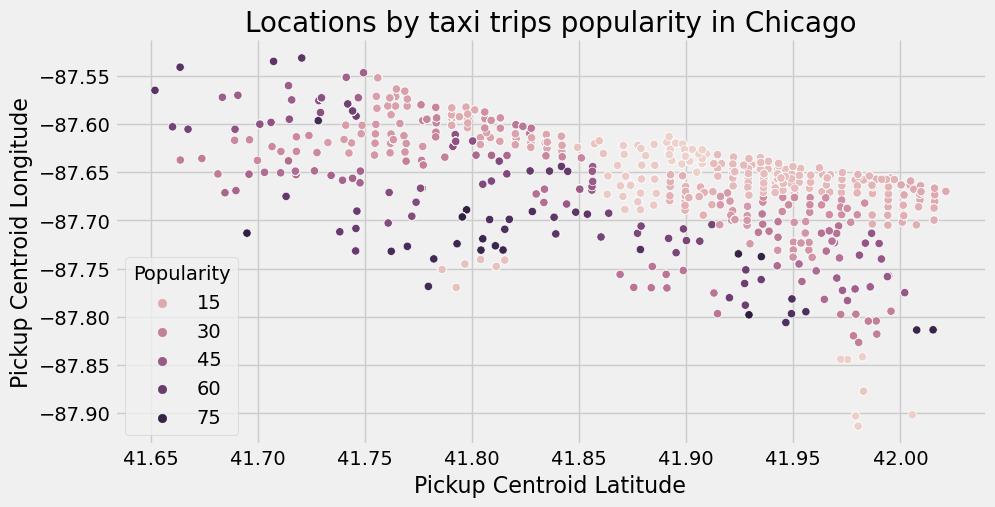

In [300]:
plt.figure(figsize=(10, 5))
geo_plot = sns.scatterplot(
    data=geo_features_pickup,
    x="Pickup Centroid Latitude",
    y="Pickup Centroid Longitude",
    hue="Popularity",
)
plt.title("Locations by taxi trips popularity in Chicago");

Least popular locations seem to predominantly be situated at the edges of the city.

In [ ]:
popular_locations_top = popularity.head(5)

In [ ]:
unpopular_locations_top = popularity.tail(5)

### Time features for trips count and payment total

For trips count and total hourly revenue, rolling mean and lag features will be added.

In [64]:
counts = grouped.count()
trip_total_aggs = agg_2_sum_and_median.select(["date", "location", "trip_total_agg"])

In [65]:
trips_count = counts.join(trip_total_aggs, on=["date", "location"], how="left")

In [66]:
trips_count = trips_count.toPandas()

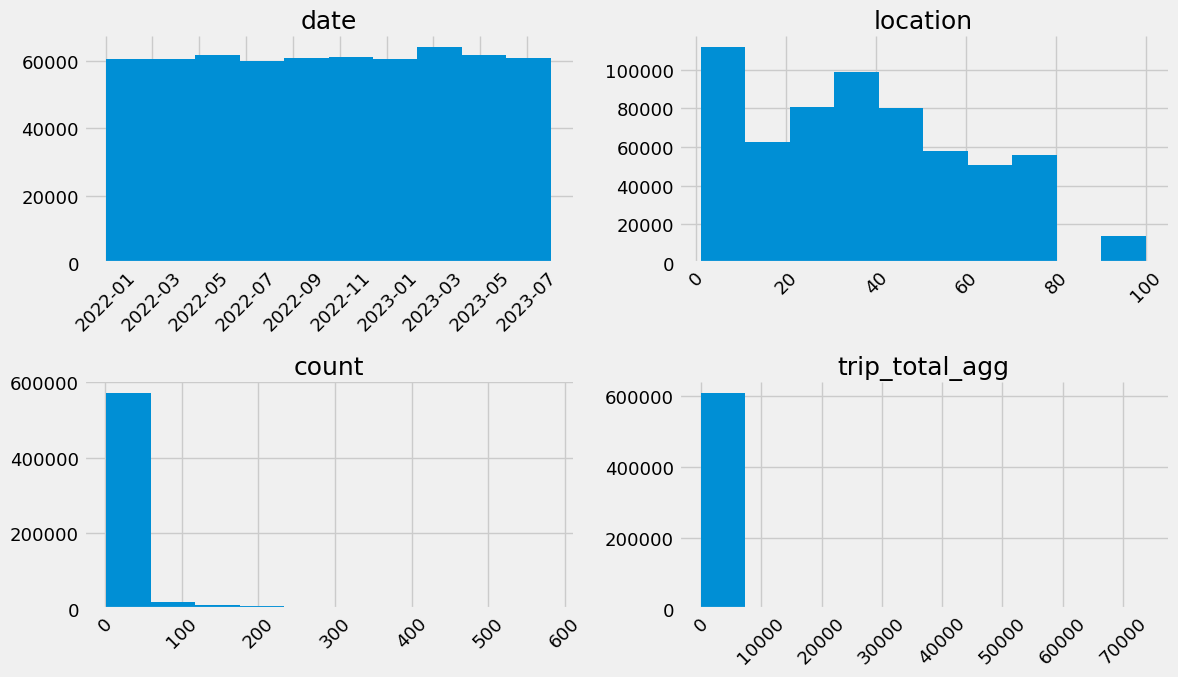

In [304]:
trips_count.hist(figsize=(12, 7), xrot=45)
plt.tight_layout()

Taking a closer look at the taxo trips count:

In [305]:
trips_count_grouped = trips_count.groupby(["date"]).sum().drop("location", axis=1)

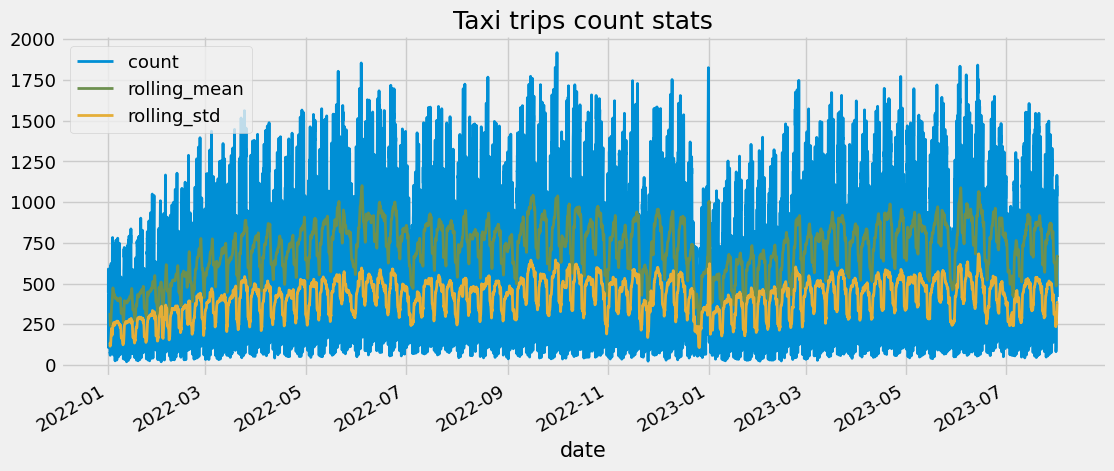

In [306]:
trips_count_grouped["count"].plot(figsize=(12, 5))
trips_count_grouped["count"].shift().rolling(24).mean().plot(color="#6d904f")
trips_count_grouped["count"].shift().rolling(24).std().plot(color="#e5ae38")
plt.title("Taxi trips count stats")
plt.legend(["count", "rolling_mean", "rolling_std"])
plt.show()

The mean and std seem to be non-stationary. There seems to be seasonality in data. STL decomposition will be used to get more valuable information:

In [70]:
trips_count_grouped = trips_count_grouped["count"]  # convert to series
trips_count_grouped = trips_count_grouped.resample("H").sum()  # fake resample to fit in STL

In [71]:
df_decomposed = STL(trips_count_grouped, robust=True).fit()

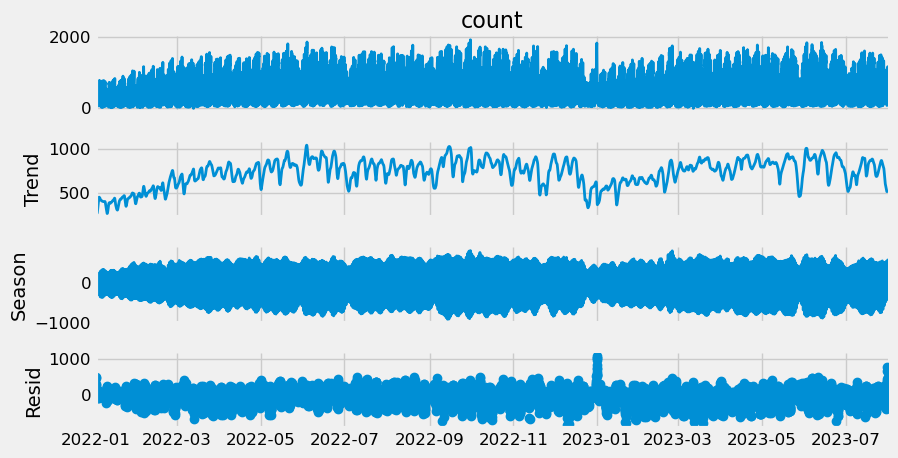

In [72]:
fig = df_decomposed.plot()
fig.set_figwidth(10)

The trend tells us that there is less trips overall in Jan and Feb while in other months there are fluctuations from 500 to 1000 daily trips without explicit trend. There is daily seasonality with mean value that looks stationary. In more detail:

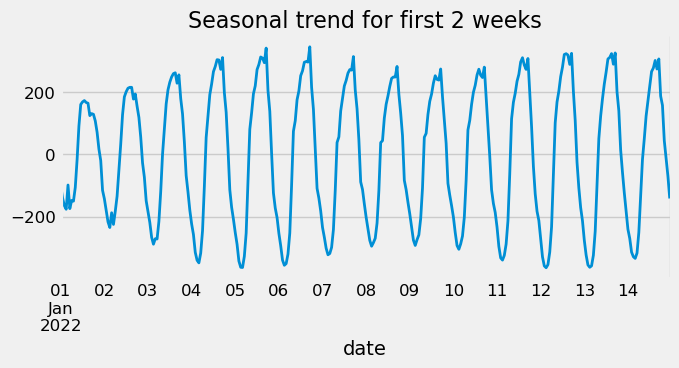

In [73]:
df_decomposed.seasonal.head(24 * 14).plot(figsize=(7, 3))
plt.title("Seasonal trend for first 2 weeks")
plt.show()

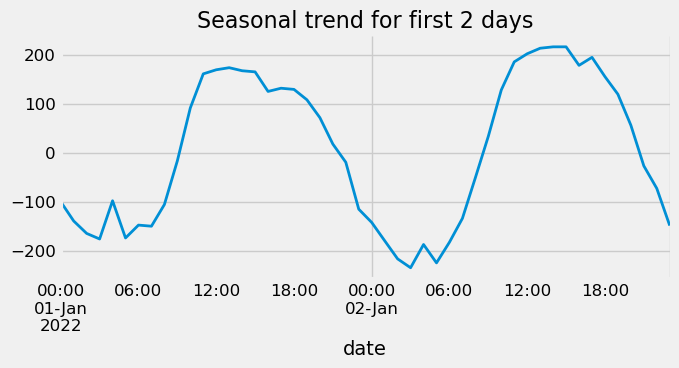

In [74]:
df_decomposed.seasonal.head(2 * 24).plot(figsize=(7, 3))
plt.title("Seasonal trend for first 2 days")
plt.show()

---

Optimal values for rolling mean size and lag features count will be calculated using custom function.  
It finds the optimal values for these parameters, as well as the necessity to add the STL decomposed features.

The optimal parameters will be calculated using Linear Regression predictions for only one popular community area (location), but will further be used for all other locations as well.

In [75]:
popularity.head(3)

8     1.0
76    2.0
32    3.0
Name: Pickup Community Area, dtype: float64

In [76]:
popular_location = popularity.index.tolist()[2]

In [77]:
# find best params for a popular location

df = (
    trips_count[trips_count["location"] == popular_location]
    .drop("location", axis=1)
    .set_index("date")
    .resample("1H")
    .sum()
)

cv_params = {
    "max_lag": [1, 12, 24, 30, 40, 48, 60, 72, 168],
    "rolling_mean_size": [1, 12, 15, 20, 24, 48, 72],
    "add_decomposed": [False, True],
}

data = TSDataManager(df)
cv_result = data.grid_search(LinearRegression(), cv_params)

100%|██████████| 126/126 [02:40<00:00,  1.28s/it]


In [307]:
# optimal parameters
cv_result

{'best_score_RMSE': 21.117082151779336,
 'best_params': {'max_lag': 168,
  'rolling_mean_size': 12,
  'add_decomposed': True},
 'best_model': LinearRegression()}

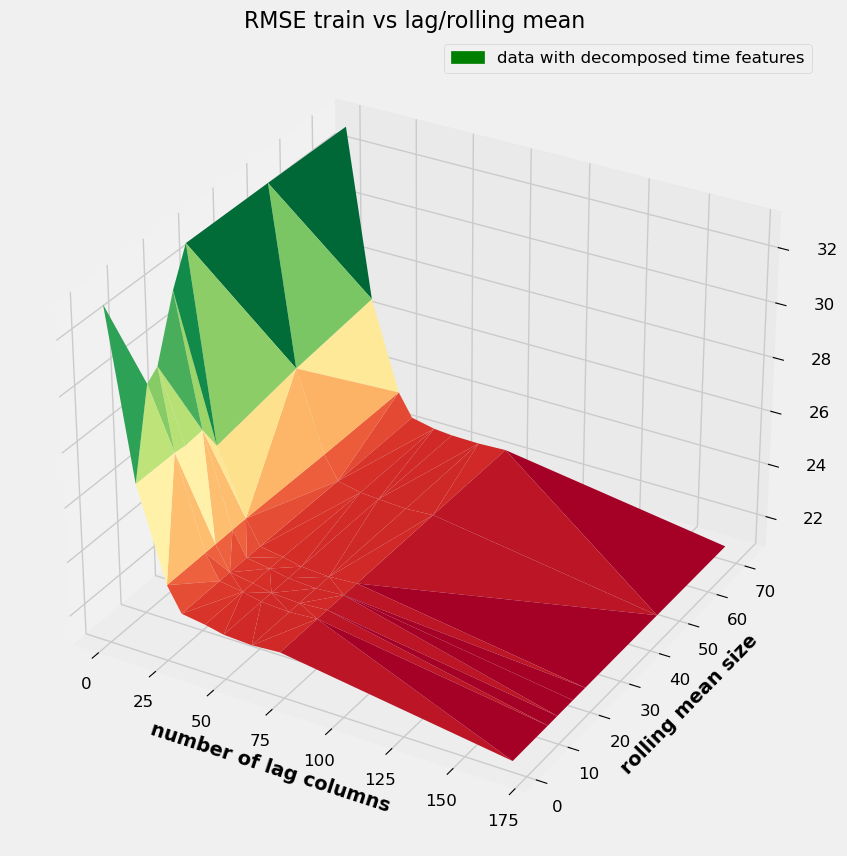

In [79]:
data.plot(plot_non_decomposed=False);

168 lag columns (1 week) and 12 hours rolling mean size (half a day) are the optimal parameters that will be used for feature generation for all locations.  
  
Lag and rolling mean columns for trips count and aggregate hourly revenue will be created separately for every location. Then the resulting dfs for every location will be concatenated.

In [80]:
def make_time_features_by_location(input_df, ts_params):
    """
    Makes lags / rolling mean for every location separately, then concatenates dfs for every location.
    """
    # same functionality is achievable using groupby instead of loop. but no

    dfs_with_added_time_features = dict()
    input_df = input_df.copy()

    for i in tqdm(input_df.location.unique()):
        df = input_df[input_df["location"] == i].drop("location", axis=1).set_index("date").resample("1H").sum()

        data = TSDataManager(df)

        _, modified_df = data.make_features(**ts_params)
        modified_df.insert(0, "location", i)

        dfs_with_added_time_features[i] = modified_df.copy()

    time_features = pd.concat([df for df in dfs_with_added_time_features.values()])
    return time_features

In [81]:
best_ts_params = cv_result["best_params"]
best_ts_params["rolling_mean_size"] = 12

time_features = make_time_features_by_location(trips_count, best_ts_params)

100%|██████████| 78/78 [02:51<00:00,  2.20s/it]


In [82]:
# time_features = time_features[time_features['count'] > 0]  # remove all hours without trips
# assert len(time_features) == len(trips_count)

## Machine learning

### Merging dfs and final data preparation

Join the time features and non-time features:

In [83]:
final_df = time_features.merge(
    non_time_features, left_on=["date", "location"], right_on=["date", "location"], how="left"
)

In [84]:
final_df = final_df.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))  # rename columns to be machine readable
final_df = final_df.loc[:, ~final_df.columns.duplicated()].copy()  # drop duplicate columns, if any
final_df = final_df.set_index("date")

In [85]:
# remove first week containing gaps in lag columns
final_df = final_df[START_DATE:]

Fill the first hour with 0 trips using the data from previous hour, fill all other rows with 0:

In [86]:
final_df = final_df.sort_values(["location", "date"])

In [87]:
final_df = final_df.fillna(method="ffill", limit=1)  # fill 0-trip hours with previous hour values
final_df = final_df.fillna(0)

Add an artificial feature that clusters the regions by relatively large prediction error and geographical proximity. Regions 56 and 76 are airports.

In [88]:
# clusterize regions with worse predictions by geographical proximity

cluster_dict = dict()

pop_dict = {
    1: [11, 12, 15, 17, 18, 20],
    2: [23, 26],
    3: [30, 31],
    4: [47, 50, 51, 52, 54, 55],
    5: [63, 65, 67],
    6: [72, 74],
    7: [56, 76],
}

for key, value in pop_dict.items():
    for el in value:
        cluster_dict[el] = key

In [89]:
final_df["cluster"] = final_df["location"].map(cluster_dict)
final_df["cluster"] = final_df["cluster"].fillna(0)

In [90]:
final_df.head(5)

,location,count,count_lag_1,count_lag_2,count_lag_3,count_lag_4,count_lag_5,count_lag_6,count_lag_7,count_lag_8,...,tolls_median_lag1,extras_agg_lag1,extras_median_lag1,trip_total_agg_lag1,trip_total_median_lag1,mean_speed_median_lag1,pickup_census_mode_lag1,dropoff_census_mode_lag1,popularity,cluster
date,,,,,,,,,,,,,,,,,,,,,
2022-01-08 00:00:00,1,2,2.0,1.0,5.0,4.0,3.0,3.0,5.0,12.0,...,0.0,0.0,0.0,43.50,21.75,24.931073,1.704901e+10,1.704901e+10,15.0,0.0
2022-01-08 01:00:00,1,1,2.0,2.0,1.0,5.0,4.0,3.0,3.0,5.0,...,0.0,0.0,0.0,11.00,5.50,12.610315,1.704901e+10,1.704901e+10,15.0,0.0
2022-01-08 02:00:00,1,1,1.0,2.0,2.0,1.0,5.0,4.0,3.0,3.0,...,0.0,0.0,0.0,8.00,8.00,11.071429,1.704901e+10,1.704901e+10,15.0,0.0
2022-01-08 03:00:00,1,2,1.0,1.0,2.0,2.0,1.0,5.0,4.0,3.0,...,0.0,0.0,0.0,11.75,11.75,9.782609,1.704901e+10,1.704901e+10,15.0,0.0
2022-01-08 04:00:00,1,2,2.0,1.0,1.0,2.0,2.0,1.0,5.0,4.0,...,0.0,0.0,0.0,28.00,14.00,20.388927,1.704901e+10,1.704901e+10,15.0,0.0


### Train/test split

Size of train data is 70%, validation and test data are both 15%.

In [91]:
val_iloc = -int(len(final_df.index.unique()) * 2 * TEST_SIZE)
test_iloc = -int(len(final_df.index.unique()) * TEST_SIZE)

val_index = final_df.index.unique()[val_iloc]
test_index = final_df.index.unique()[test_iloc]

In [92]:
str(val_index)

'2023-02-11 00:00:00'

In [93]:
str(test_index)

'2023-05-07 12:00:00'

In [94]:
X_train = final_df.drop("count", axis=1).loc[: str(val_index)]
y_train = final_df["count"].loc[: str(val_index)]


X_valid = final_df.drop("count", axis=1).loc[str(val_index) : str(test_index)]
y_valid = final_df["count"].loc[str(val_index) : str(test_index)]


X_test = final_df.drop("count", axis=1).loc[str(test_index) :]
y_test = final_df["count"].loc[str(test_index) :]

In [333]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(747006, 416)
(160134, 416)
(159861, 416)


### Getting predictions (Approach I, aggregate predictions)

The first approach is to have 1 model for all data. An ensemble of LGBMRegressor and CatBoost regressor is used for this purpose.

In [96]:
gbm_params = {
    "learning_rate": 0.1,
    "max_bin": 255,
    "n_estimators": 1000,
    "num_leaves": 400,
    "max_depth": 20,
    "early_stopping_round": 50,
}

In [97]:
gbm = lgb.LGBMRegressor(n_jobs=-1, application="regression", metric="mae", **gbm_params)
gbm.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric="mae")

preds_gbm = gbm.predict(X_valid)
mean_absolute_error(y_valid, preds_gbm)

[1]	valid_0's l1: 12.5311
[2]	valid_0's l1: 11.3142
[3]	valid_0's l1: 10.2219
[4]	valid_0's l1: 9.23966
[5]	valid_0's l1: 8.36372
[6]	valid_0's l1: 7.57724
[7]	valid_0's l1: 6.87391
[8]	valid_0's l1: 6.24699
[9]	valid_0's l1: 5.68966
[10]	valid_0's l1: 5.19492
[11]	valid_0's l1: 4.75626
[12]	valid_0's l1: 4.36611
[13]	valid_0's l1: 4.02453
[14]	valid_0's l1: 3.72424
[15]	valid_0's l1: 3.46292
[16]	valid_0's l1: 3.236
[17]	valid_0's l1: 3.03673
[18]	valid_0's l1: 2.86354
[19]	valid_0's l1: 2.71458
[20]	valid_0's l1: 2.58507
[21]	valid_0's l1: 2.47158
[22]	valid_0's l1: 2.37679
[23]	valid_0's l1: 2.29482
[24]	valid_0's l1: 2.22493
[25]	valid_0's l1: 2.16606
[26]	valid_0's l1: 2.11051
[27]	valid_0's l1: 2.06441
[28]	valid_0's l1: 2.02491
[29]	valid_0's l1: 1.99014
[30]	valid_0's l1: 1.9601
[31]	valid_0's l1: 1.93426
[32]	valid_0's l1: 1.91304
[33]	valid_0's l1: 1.89273
[34]	valid_0's l1: 1.87555
[35]	valid_0's l1: 1.86112
[36]	valid_0's l1: 1.84733
[37]	valid_0's l1: 1.83534
[38]	valid_0'

[299]	valid_0's l1: 1.674
[300]	valid_0's l1: 1.67396
[301]	valid_0's l1: 1.67398
[302]	valid_0's l1: 1.67394
[303]	valid_0's l1: 1.674
[304]	valid_0's l1: 1.67394
[305]	valid_0's l1: 1.67385
[306]	valid_0's l1: 1.67381
[307]	valid_0's l1: 1.67384
[308]	valid_0's l1: 1.67389
[309]	valid_0's l1: 1.67392
[310]	valid_0's l1: 1.67391
[311]	valid_0's l1: 1.67384
[312]	valid_0's l1: 1.67382
[313]	valid_0's l1: 1.67376
[314]	valid_0's l1: 1.67372
[315]	valid_0's l1: 1.67329
[316]	valid_0's l1: 1.67329
[317]	valid_0's l1: 1.67319
[318]	valid_0's l1: 1.67311
[319]	valid_0's l1: 1.6731
[320]	valid_0's l1: 1.67319
[321]	valid_0's l1: 1.67325
[322]	valid_0's l1: 1.6732
[323]	valid_0's l1: 1.67327
[324]	valid_0's l1: 1.6732
[325]	valid_0's l1: 1.67314
[326]	valid_0's l1: 1.67313
[327]	valid_0's l1: 1.67283
[328]	valid_0's l1: 1.67174
[329]	valid_0's l1: 1.67175
[330]	valid_0's l1: 1.67167
[331]	valid_0's l1: 1.67169
[332]	valid_0's l1: 1.6717
[333]	valid_0's l1: 1.67055
[334]	valid_0's l1: 1.67055


[593]	valid_0's l1: 1.6572
[594]	valid_0's l1: 1.65723
[595]	valid_0's l1: 1.65723
[596]	valid_0's l1: 1.65722
[597]	valid_0's l1: 1.65726
[598]	valid_0's l1: 1.65715
[599]	valid_0's l1: 1.65719
[600]	valid_0's l1: 1.65718
[601]	valid_0's l1: 1.6572
[602]	valid_0's l1: 1.6572
[603]	valid_0's l1: 1.65698
[604]	valid_0's l1: 1.6569
[605]	valid_0's l1: 1.65691
[606]	valid_0's l1: 1.65688
[607]	valid_0's l1: 1.65689
[608]	valid_0's l1: 1.65689
[609]	valid_0's l1: 1.65691
[610]	valid_0's l1: 1.65692
[611]	valid_0's l1: 1.65698
[612]	valid_0's l1: 1.65698
[613]	valid_0's l1: 1.65696
[614]	valid_0's l1: 1.65693
[615]	valid_0's l1: 1.65695
[616]	valid_0's l1: 1.65697
[617]	valid_0's l1: 1.65696
[618]	valid_0's l1: 1.65694
[619]	valid_0's l1: 1.65691
[620]	valid_0's l1: 1.65668
[621]	valid_0's l1: 1.65669
[622]	valid_0's l1: 1.65663
[623]	valid_0's l1: 1.65661
[624]	valid_0's l1: 1.65659
[625]	valid_0's l1: 1.6566
[626]	valid_0's l1: 1.65663
[627]	valid_0's l1: 1.65662
[628]	valid_0's l1: 1.656

[887]	valid_0's l1: 1.65069
[888]	valid_0's l1: 1.65069
[889]	valid_0's l1: 1.65068
[890]	valid_0's l1: 1.6507
[891]	valid_0's l1: 1.65071
[892]	valid_0's l1: 1.65074
[893]	valid_0's l1: 1.65074
[894]	valid_0's l1: 1.65073
[895]	valid_0's l1: 1.65075
[896]	valid_0's l1: 1.65072
[897]	valid_0's l1: 1.65071
[898]	valid_0's l1: 1.65071
[899]	valid_0's l1: 1.65069
[900]	valid_0's l1: 1.65073
[901]	valid_0's l1: 1.65075
[902]	valid_0's l1: 1.65074
[903]	valid_0's l1: 1.65076
[904]	valid_0's l1: 1.65079
[905]	valid_0's l1: 1.65076
[906]	valid_0's l1: 1.65074


1.6504607008043304

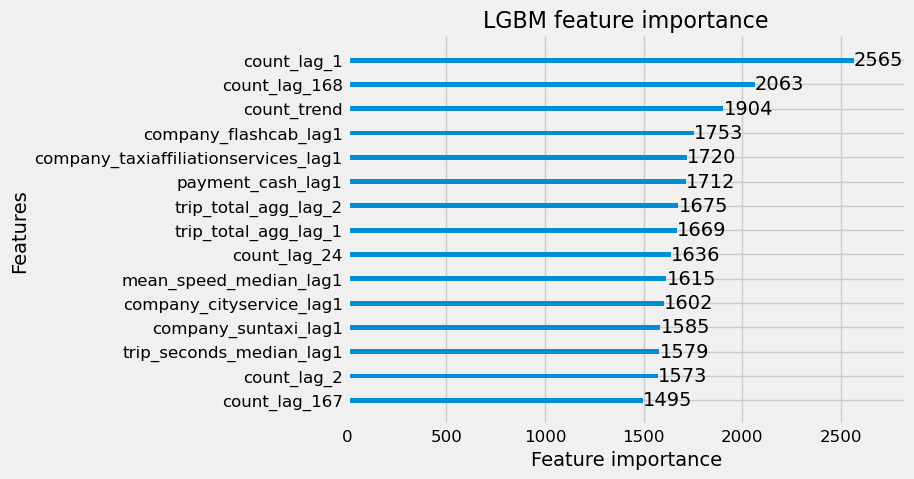

In [98]:
lgb.plot_importance(gbm, max_num_features=15, title="LGBM feature importance")
plt.show()

Most important features for LGBM are trips count for previous hour, trips count a week ago and the trend of trips count from STL decomposition.

In [99]:
cbr_params = {
    "iterations": 3000,
    "learning_rate": 0.3,
    "max_leaves": 400,
    "thread_count": -1,
    "loss_function": "MAE",
    "grow_policy": "Lossguide",
    "langevin": True,
    "early_stopping_rounds": 50,
    "boosting_type": "Plain",  # should increase speed
    #     'logging_level': 'Silent'
    "verbose": 100,
    "eval_metric": "MAE",
}

In [100]:
cbr = CatBoostRegressor(**cbr_params)
cbr.fit(X_train, y_train, eval_set=(X_valid, y_valid))

preds_cbr = cbr.predict(X_valid)
mean_absolute_error(y_valid, preds_cbr)

0:	learn: 7.6732405	test: 8.2968397	best: 8.2968397 (0)	total: 769ms	remaining: 38m 25s
100:	learn: 1.7453456	test: 1.9043962	best: 1.9043962 (100)	total: 1m 11s	remaining: 34m 6s
200:	learn: 1.6069980	test: 1.7942526	best: 1.7942526 (200)	total: 2m 22s	remaining: 33m 4s
300:	learn: 1.5578931	test: 1.7633814	best: 1.7633814 (300)	total: 3m 30s	remaining: 31m 26s
400:	learn: 1.5120358	test: 1.7388448	best: 1.7388448 (400)	total: 4m 39s	remaining: 30m 13s
500:	learn: 1.4677107	test: 1.7218975	best: 1.7218975 (500)	total: 5m 52s	remaining: 29m 15s
600:	learn: 1.4372668	test: 1.7110975	best: 1.7110975 (600)	total: 7m 1s	remaining: 28m 1s
700:	learn: 1.4131700	test: 1.6988934	best: 1.6988934 (700)	total: 8m 9s	remaining: 26m 44s
800:	learn: 1.3828323	test: 1.6866187	best: 1.6866088 (798)	total: 9m 20s	remaining: 25m 37s
900:	learn: 1.3661090	test: 1.6793417	best: 1.6793417 (900)	total: 10m 30s	remaining: 24m 28s
1000:	learn: 1.3488285	test: 1.6753651	best: 1.6752940 (995)	total: 11m 41s	rem

1.6124475502724738

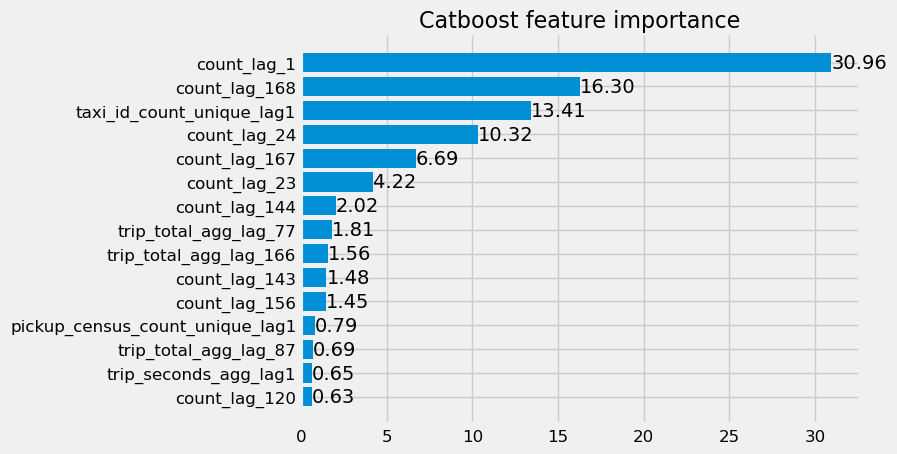

In [103]:
fi = pd.Series(cbr.feature_importances_, index=cbr.feature_names_).sort_values(ascending=False)
fi_short = fi[:15][::-1]

ax = plt.barh(fi_short.index, fi_short.values)
plt.bar_label(ax, fmt="%.2f")
plt.title("Catboost feature importance")
plt.show()

Most important features for CatBoost are trips count for previous hour, trips count a week ago and the count of unique taxi ids for the previous hour.

Getting the final combined prediction:

In [255]:
combined = (0.75 * preds_gbm + 1.25 * preds_cbr) / 2
combined = list(map(lambda x: x if x >= 0 else 0, combined))

All the values less than 0 are zeroed as there can't be less than 0 trips per hour. Final MAE score for first approach:

In [256]:
mean_absolute_error(y_valid, combined)

1.5885181006108995

### Getting predictions (Approach II, separate predictions)

The second approach is to have 1 model for every location (community area). Mean MAE for all regions is used as a metric in this case.

In [104]:
cbr_params = {
    "iterations": 3000,
    "learning_rate": 0.2,
    "max_leaves": 400,
    "thread_count": -1,
    "loss_function": "MAE",
    "grow_policy": "Lossguide",
    "langevin": True,
    "early_stopping_rounds": 100,
    "boosting_type": "Plain",  # should increase speed
    #     'logging_level': 'Silent'
    "verbose": 100,
    "eval_metric": "MAE",
}

In [105]:
gbm_params = {
    "learning_rate": 0.2,  # has no impact
    "max_bin": 255,
    "n_estimators": 1000,
    "num_leaves": 400,
    "early_stopping_round": 50,
    "verbose": -1,
    "max_depth": 20,
}

In [106]:
predictions = []

for i in tqdm(X_train["location"].unique()):
    X_train_subset = X_train[X_train["location"] == i]
    y_train_subset = y_train[X_train["location"] == i]

    X_valid_subset = X_valid[X_valid["location"] == i]
    y_valid_subset = y_valid[X_valid["location"] == i]

    cbr = CatBoostRegressor(**cbr_params)
    cbr.fit(X_train_subset, y_train_subset, eval_set=(X_valid_subset, y_valid_subset))

    gbm = lgb.LGBMRegressor(metric="mae", **gbm_params)
    gbm.fit(X_train_subset, y_train_subset, eval_set=(X_valid_subset, y_valid_subset), eval_metric="mae")

    preds_gbm_partial = gbm.predict(X_valid_subset)
    preds_cbr_partial = cbr.predict(X_valid_subset)

    combined_partial = (0.75 * preds_gbm_partial + 1.25 * preds_cbr_partial) / 2
    combined_partial = list(map(lambda x: x if x >= 0 else 0, combined_partial))

    predictions.append(mean_absolute_error(y_valid_subset, combined_partial))

  0%|          | 0/78 [00:00<?, ?it/s]

0:	learn: 2.2717751	test: 2.5129068	best: 2.5129068 (0)	total: 37.1ms	remaining: 1m 51s
100:	learn: 1.0591492	test: 1.5629915	best: 1.5503937 (56)	total: 3.23s	remaining: 1m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.550393716
bestIteration = 56

Shrink model to first 57 iterations.
[1]	valid_0's l1: 2.39832
[2]	valid_0's l1: 2.14591
[3]	valid_0's l1: 1.96951
[4]	valid_0's l1: 1.84341
[5]	valid_0's l1: 1.76079
[6]	valid_0's l1: 1.70303
[7]	valid_0's l1: 1.67243
[8]	valid_0's l1: 1.65148
[9]	valid_0's l1: 1.6345
[10]	valid_0's l1: 1.62301
[11]	valid_0's l1: 1.61906
[12]	valid_0's l1: 1.62323
[13]	valid_0's l1: 1.62145
[14]	valid_0's l1: 1.62169
[15]	valid_0's l1: 1.62206
[16]	valid_0's l1: 1.61992
[17]	valid_0's l1: 1.61943
[18]	valid_0's l1: 1.62162
[19]	valid_0's l1: 1.62299
[20]	valid_0's l1: 1.62178
[21]	valid_0's l1: 1.61814
[22]	valid_0's l1: 1.61795
[23]	valid_0's l1: 1.61671
[24]	valid_0's l1: 1.61753
[25]	valid_0's l1: 1.61716
[26]	valid_0's l1: 1.

  1%|▏         | 1/78 [00:11<14:40, 11.43s/it]

0:	learn: 3.0507873	test: 3.3713580	best: 3.3713580 (0)	total: 33.1ms	remaining: 1m 39s
100:	learn: 1.2396672	test: 1.8018256	best: 1.7886836 (71)	total: 3.78s	remaining: 1m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.788683636
bestIteration = 71

Shrink model to first 72 iterations.
[1]	valid_0's l1: 3.26414
[2]	valid_0's l1: 2.8497
[3]	valid_0's l1: 2.56398
[4]	valid_0's l1: 2.37473
[5]	valid_0's l1: 2.23361
[6]	valid_0's l1: 2.12148
[7]	valid_0's l1: 2.05114
[8]	valid_0's l1: 1.99904
[9]	valid_0's l1: 1.96245
[10]	valid_0's l1: 1.93755
[11]	valid_0's l1: 1.92348
[12]	valid_0's l1: 1.9096
[13]	valid_0's l1: 1.90434
[14]	valid_0's l1: 1.90335
[15]	valid_0's l1: 1.8931
[16]	valid_0's l1: 1.89479
[17]	valid_0's l1: 1.89156
[18]	valid_0's l1: 1.88893
[19]	valid_0's l1: 1.89086
[20]	valid_0's l1: 1.8894
[21]	valid_0's l1: 1.89066
[22]	valid_0's l1: 1.89154
[23]	valid_0's l1: 1.88868
[24]	valid_0's l1: 1.88949
[25]	valid_0's l1: 1.89087
[26]	valid_0's l1: 1.890

  3%|▎         | 2/78 [00:20<12:54, 10.19s/it]

0:	learn: 5.7280976	test: 6.6493901	best: 6.6493901 (0)	total: 50.1ms	remaining: 2m 30s
100:	learn: 1.9356715	test: 2.8722975	best: 2.8515025 (30)	total: 4.08s	remaining: 1m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.85150253
bestIteration = 30

Shrink model to first 31 iterations.
[1]	valid_0's l1: 6.4893
[2]	valid_0's l1: 5.54742
[3]	valid_0's l1: 4.84177
[4]	valid_0's l1: 4.31808
[5]	valid_0's l1: 3.95343
[6]	valid_0's l1: 3.67349
[7]	valid_0's l1: 3.48076
[8]	valid_0's l1: 3.34456
[9]	valid_0's l1: 3.23974
[10]	valid_0's l1: 3.16581
[11]	valid_0's l1: 3.10757
[12]	valid_0's l1: 3.07179
[13]	valid_0's l1: 3.05309
[14]	valid_0's l1: 3.04085
[15]	valid_0's l1: 3.02971
[16]	valid_0's l1: 3.02297
[17]	valid_0's l1: 3.0212
[18]	valid_0's l1: 3.01655
[19]	valid_0's l1: 3.01666
[20]	valid_0's l1: 3.0124
[21]	valid_0's l1: 3.00962
[22]	valid_0's l1: 3.0117
[23]	valid_0's l1: 3.00819
[24]	valid_0's l1: 3.00663
[25]	valid_0's l1: 3.00529
[26]	valid_0's l1: 3.0019

  4%|▍         | 3/78 [00:30<12:20,  9.87s/it]

[78]	valid_0's l1: 3.0062
[79]	valid_0's l1: 3.00541
[80]	valid_0's l1: 3.00542
[81]	valid_0's l1: 3.00534
0:	learn: 1.8081017	test: 1.8881626	best: 1.8881626 (0)	total: 31.7ms	remaining: 1m 35s
100:	learn: 0.8635527	test: 1.3122953	best: 1.3047633 (43)	total: 4.14s	remaining: 1m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.304763323
bestIteration = 43

Shrink model to first 44 iterations.
[1]	valid_0's l1: 1.87516
[2]	valid_0's l1: 1.72328
[3]	valid_0's l1: 1.60897
[4]	valid_0's l1: 1.52991
[5]	valid_0's l1: 1.47807
[6]	valid_0's l1: 1.43466
[7]	valid_0's l1: 1.4114
[8]	valid_0's l1: 1.3894
[9]	valid_0's l1: 1.3742
[10]	valid_0's l1: 1.36952
[11]	valid_0's l1: 1.36211
[12]	valid_0's l1: 1.35645
[13]	valid_0's l1: 1.35331
[14]	valid_0's l1: 1.34968
[15]	valid_0's l1: 1.34788
[16]	valid_0's l1: 1.34618
[17]	valid_0's l1: 1.34592
[18]	valid_0's l1: 1.34551
[19]	valid_0's l1: 1.34649
[20]	valid_0's l1: 1.34471
[21]	valid_0's l1: 1.34392
[22]	valid_0's l1: 1.344

  5%|▌         | 4/78 [00:43<13:51, 11.24s/it]

0:	learn: 1.3709293	test: 1.5125173	best: 1.5125173 (0)	total: 27.1ms	remaining: 1m 21s
100:	learn: 0.7517146	test: 1.0839411	best: 1.0701870 (55)	total: 2.49s	remaining: 1m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.070187033
bestIteration = 55

Shrink model to first 56 iterations.
[1]	valid_0's l1: 1.50348
[2]	valid_0's l1: 1.40673
[3]	valid_0's l1: 1.34319
[4]	valid_0's l1: 1.29344
[5]	valid_0's l1: 1.25747
[6]	valid_0's l1: 1.21846
[7]	valid_0's l1: 1.19574
[8]	valid_0's l1: 1.17936
[9]	valid_0's l1: 1.16394
[10]	valid_0's l1: 1.15682
[11]	valid_0's l1: 1.14773
[12]	valid_0's l1: 1.14595
[13]	valid_0's l1: 1.14332
[14]	valid_0's l1: 1.14181
[15]	valid_0's l1: 1.14198
[16]	valid_0's l1: 1.13996
[17]	valid_0's l1: 1.14009
[18]	valid_0's l1: 1.13867
[19]	valid_0's l1: 1.13734
[20]	valid_0's l1: 1.13746
[21]	valid_0's l1: 1.13799
[22]	valid_0's l1: 1.13831
[23]	valid_0's l1: 1.13776
[24]	valid_0's l1: 1.13875
[25]	valid_0's l1: 1.13999
[26]	valid_0's l1: 1

  6%|▋         | 5/78 [00:50<11:56,  9.82s/it]

[64]	valid_0's l1: 1.14809
[65]	valid_0's l1: 1.14817
[66]	valid_0's l1: 1.1482
[67]	valid_0's l1: 1.14831
[68]	valid_0's l1: 1.14824
[69]	valid_0's l1: 1.14849
0:	learn: 11.8573866	test: 12.2414018	best: 12.2414018 (0)	total: 30.6ms	remaining: 1m 31s
100:	learn: 3.8324756	test: 5.4029281	best: 5.4027773 (99)	total: 4.39s	remaining: 2m 6s
200:	learn: 3.1005698	test: 5.3855741	best: 5.3796760 (161)	total: 8.5s	remaining: 1m 58s
300:	learn: 2.7260732	test: 5.3795865	best: 5.3737977 (240)	total: 12.6s	remaining: 1m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 5.373797685
bestIteration = 240

Shrink model to first 241 iterations.
[1]	valid_0's l1: 11.8043
[2]	valid_0's l1: 10.1208
[3]	valid_0's l1: 8.88283
[4]	valid_0's l1: 7.94356
[5]	valid_0's l1: 7.23461
[6]	valid_0's l1: 6.72268
[7]	valid_0's l1: 6.37868
[8]	valid_0's l1: 6.14967
[9]	valid_0's l1: 5.965
[10]	valid_0's l1: 5.82537
[11]	valid_0's l1: 5.74117
[12]	valid_0's l1: 5.69647
[13]	valid_0's l1: 5.66097


  8%|▊         | 6/78 [01:08<15:07, 12.60s/it]

[71]	valid_0's l1: 5.58242
0:	learn: 8.1895364	test: 7.8505592	best: 7.8505592 (0)	total: 33.5ms	remaining: 1m 40s
100:	learn: 2.7475224	test: 3.9344454	best: 3.9344454 (100)	total: 4.23s	remaining: 2m 1s
200:	learn: 2.2139846	test: 3.9067262	best: 3.9057771 (199)	total: 8.23s	remaining: 1m 54s
300:	learn: 1.9105446	test: 3.9004906	best: 3.8988639 (289)	total: 12.2s	remaining: 1m 49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 3.898863922
bestIteration = 289

Shrink model to first 290 iterations.
[1]	valid_0's l1: 7.82073
[2]	valid_0's l1: 6.78982
[3]	valid_0's l1: 6.01676
[4]	valid_0's l1: 5.44254
[5]	valid_0's l1: 5.03476
[6]	valid_0's l1: 4.75067
[7]	valid_0's l1: 4.53712
[8]	valid_0's l1: 4.38163
[9]	valid_0's l1: 4.26655
[10]	valid_0's l1: 4.20231
[11]	valid_0's l1: 4.15291
[12]	valid_0's l1: 4.10657
[13]	valid_0's l1: 4.07809
[14]	valid_0's l1: 4.06691
[15]	valid_0's l1: 4.04912
[16]	valid_0's l1: 4.0394
[17]	valid_0's l1: 4.02981
[18]	valid_0's l1: 4.01697

  9%|▉         | 7/78 [01:27<17:25, 14.72s/it]

0:	learn: 76.9805981	test: 75.1494386	best: 75.1494386 (0)	total: 41ms	remaining: 2m 2s
100:	learn: 10.9749914	test: 16.2512697	best: 16.2395559 (97)	total: 5.36s	remaining: 2m 33s
200:	learn: 8.6294686	test: 16.1314733	best: 16.1207554 (198)	total: 10.3s	remaining: 2m 23s
300:	learn: 7.3888137	test: 16.0252315	best: 16.0075512 (283)	total: 15.3s	remaining: 2m 17s
400:	learn: 6.5649238	test: 15.9661459	best: 15.9578979 (396)	total: 20.4s	remaining: 2m 11s
500:	learn: 6.0442050	test: 15.9250737	best: 15.9220115 (486)	total: 25.5s	remaining: 2m 7s
600:	learn: 5.7089584	test: 15.8834855	best: 15.8797515 (598)	total: 30.5s	remaining: 2m 1s
700:	learn: 5.4448602	test: 15.8588225	best: 15.8588225 (700)	total: 35.5s	remaining: 1m 56s
800:	learn: 5.2394495	test: 15.8097013	best: 15.8070916 (797)	total: 40.4s	remaining: 1m 50s
900:	learn: 5.0327587	test: 15.7654768	best: 15.7654768 (900)	total: 45.6s	remaining: 1m 46s
1000:	learn: 4.8440041	test: 15.7324953	best: 15.7294625 (989)	total: 50.7s	r

 10%|█         | 8/78 [04:13<1:13:17, 62.82s/it]

0:	learn: 0.1063172	test: 0.1552849	best: 0.1552849 (0)	total: 22.6ms	remaining: 1m 7s
100:	learn: 0.0226468	test: 0.0631162	best: 0.0568763 (28)	total: 2.72s	remaining: 1m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05687630624
bestIteration = 28

Shrink model to first 29 iterations.
[1]	valid_0's l1: 0.223322
[2]	valid_0's l1: 0.188517
[3]	valid_0's l1: 0.160831
[4]	valid_0's l1: 0.139041
[5]	valid_0's l1: 0.123034
[6]	valid_0's l1: 0.110382
[7]	valid_0's l1: 0.103288
[8]	valid_0's l1: 0.0966914
[9]	valid_0's l1: 0.0923131
[10]	valid_0's l1: 0.0902577
[11]	valid_0's l1: 0.0887403
[12]	valid_0's l1: 0.0877831
[13]	valid_0's l1: 0.0877888
[14]	valid_0's l1: 0.0875084
[15]	valid_0's l1: 0.0875331
[16]	valid_0's l1: 0.0869436
[17]	valid_0's l1: 0.0869829
[18]	valid_0's l1: 0.0867187
[19]	valid_0's l1: 0.0865921
[20]	valid_0's l1: 0.0867698
[21]	valid_0's l1: 0.086711
[22]	valid_0's l1: 0.0868246
[23]	valid_0's l1: 0.0865123
[24]	valid_0's l1: 0.0865751
[25]	v

 12%|█▏        | 9/78 [04:18<51:22, 44.67s/it]  

[60]	valid_0's l1: 0.0913321
[61]	valid_0's l1: 0.0912304
[62]	valid_0's l1: 0.0914328
[63]	valid_0's l1: 0.0914706
[64]	valid_0's l1: 0.0914974
[65]	valid_0's l1: 0.0915746
[66]	valid_0's l1: 0.0917171
[67]	valid_0's l1: 0.0919854
[68]	valid_0's l1: 0.09192
[69]	valid_0's l1: 0.0922035
[70]	valid_0's l1: 0.0920915
[71]	valid_0's l1: 0.0920928
[72]	valid_0's l1: 0.0923669
[73]	valid_0's l1: 0.0923344
0:	learn: 0.9940891	test: 1.2297116	best: 1.2297116 (0)	total: 22.8ms	remaining: 1m 8s
100:	learn: 0.5985947	test: 1.0086590	best: 0.9945500 (58)	total: 3.27s	remaining: 1m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9945499814
bestIteration = 58

Shrink model to first 59 iterations.
[1]	valid_0's l1: 1.20632
[2]	valid_0's l1: 1.14493
[3]	valid_0's l1: 1.10963
[4]	valid_0's l1: 1.09226
[5]	valid_0's l1: 1.08066
[6]	valid_0's l1: 1.06947
[7]	valid_0's l1: 1.05404
[8]	valid_0's l1: 1.05071
[9]	valid_0's l1: 1.05089
[10]	valid_0's l1: 1.04564
[11]	valid_0's l1: 1.

 13%|█▎        | 10/78 [04:26<37:43, 33.29s/it]

[59]	valid_0's l1: 1.05748
[60]	valid_0's l1: 1.05759
[61]	valid_0's l1: 1.0576
[62]	valid_0's l1: 1.05765
[63]	valid_0's l1: 1.05743
[64]	valid_0's l1: 1.05742
[65]	valid_0's l1: 1.05759
[66]	valid_0's l1: 1.05761
0:	learn: 0.8188359	test: 0.8126635	best: 0.8126635 (0)	total: 25.6ms	remaining: 1m 16s
100:	learn: 0.4814987	test: 0.6446849	best: 0.6442533 (98)	total: 3.23s	remaining: 1m 32s
200:	learn: 0.4040288	test: 0.6440406	best: 0.6371146 (108)	total: 6.49s	remaining: 1m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6371146115
bestIteration = 108

Shrink model to first 109 iterations.
[1]	valid_0's l1: 0.851099
[2]	valid_0's l1: 0.818406
[3]	valid_0's l1: 0.782033
[4]	valid_0's l1: 0.765204
[5]	valid_0's l1: 0.748917
[6]	valid_0's l1: 0.738439
[7]	valid_0's l1: 0.728938
[8]	valid_0's l1: 0.722814
[9]	valid_0's l1: 0.713046
[10]	valid_0's l1: 0.708114
[11]	valid_0's l1: 0.703988
[12]	valid_0's l1: 0.699967
[13]	valid_0's l1: 0.696477
[14]	valid_0's l1: 0.6

 14%|█▍        | 11/78 [04:35<29:03, 26.02s/it]

[66]	valid_0's l1: 0.699341
[67]	valid_0's l1: 0.699469
[68]	valid_0's l1: 0.69961
0:	learn: 0.7859863	test: 0.8682894	best: 0.8682894 (0)	total: 25.1ms	remaining: 1m 15s
100:	learn: 0.3869027	test: 0.5931506	best: 0.5876395 (75)	total: 3.27s	remaining: 1m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5876395206
bestIteration = 75

Shrink model to first 76 iterations.
[1]	valid_0's l1: 0.849797
[2]	valid_0's l1: 0.794322
[3]	valid_0's l1: 0.751914
[4]	valid_0's l1: 0.722386
[5]	valid_0's l1: 0.699447
[6]	valid_0's l1: 0.680833
[7]	valid_0's l1: 0.668874
[8]	valid_0's l1: 0.65888
[9]	valid_0's l1: 0.653792
[10]	valid_0's l1: 0.649142
[11]	valid_0's l1: 0.645109
[12]	valid_0's l1: 0.642783
[13]	valid_0's l1: 0.641608
[14]	valid_0's l1: 0.638168
[15]	valid_0's l1: 0.635681
[16]	valid_0's l1: 0.63533
[17]	valid_0's l1: 0.633166
[18]	valid_0's l1: 0.631124
[19]	valid_0's l1: 0.630905
[20]	valid_0's l1: 0.630606
[21]	valid_0's l1: 0.630851
[22]	valid_0's l1: 0.6316

 15%|█▌        | 12/78 [04:44<22:41, 20.63s/it]

[77]	valid_0's l1: 0.636009
[78]	valid_0's l1: 0.636137
[79]	valid_0's l1: 0.636312
[80]	valid_0's l1: 0.636342
0:	learn: 0.8546090	test: 0.8969303	best: 0.8969303 (0)	total: 24.4ms	remaining: 1m 13s
100:	learn: 0.4048027	test: 0.5396596	best: 0.5372234 (91)	total: 3.17s	remaining: 1m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5372234491
bestIteration = 91

Shrink model to first 92 iterations.
[1]	valid_0's l1: 0.878552
[2]	valid_0's l1: 0.812837
[3]	valid_0's l1: 0.763402
[4]	valid_0's l1: 0.722577
[5]	valid_0's l1: 0.68959
[6]	valid_0's l1: 0.669222
[7]	valid_0's l1: 0.648843
[8]	valid_0's l1: 0.634469
[9]	valid_0's l1: 0.622873
[10]	valid_0's l1: 0.618174
[11]	valid_0's l1: 0.615232
[12]	valid_0's l1: 0.610816
[13]	valid_0's l1: 0.606072
[14]	valid_0's l1: 0.602653
[15]	valid_0's l1: 0.598978
[16]	valid_0's l1: 0.599557
[17]	valid_0's l1: 0.598246
[18]	valid_0's l1: 0.597264
[19]	valid_0's l1: 0.5963
[20]	valid_0's l1: 0.592386
[21]	valid_0's l1: 0.5911

 17%|█▋        | 13/78 [04:52<18:16, 16.86s/it]

[72]	valid_0's l1: 0.597595
[73]	valid_0's l1: 0.597722
[74]	valid_0's l1: 0.597794
[75]	valid_0's l1: 0.597847
[76]	valid_0's l1: 0.598001
0:	learn: 1.0115059	test: 1.0406226	best: 1.0406226 (0)	total: 29.9ms	remaining: 1m 29s
100:	learn: 0.5990291	test: 0.7974846	best: 0.7902404 (58)	total: 3.43s	remaining: 1m 38s
200:	learn: 0.4821996	test: 0.7854006	best: 0.7842939 (136)	total: 6.66s	remaining: 1m 32s
300:	learn: 0.4288900	test: 0.7830559	best: 0.7813279 (245)	total: 10.2s	remaining: 1m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7813279399
bestIteration = 245

Shrink model to first 246 iterations.
[1]	valid_0's l1: 1.08795
[2]	valid_0's l1: 1.02214
[3]	valid_0's l1: 0.970318
[4]	valid_0's l1: 0.93613
[5]	valid_0's l1: 0.907656
[6]	valid_0's l1: 0.892895
[7]	valid_0's l1: 0.876486
[8]	valid_0's l1: 0.864574
[9]	valid_0's l1: 0.857156
[10]	valid_0's l1: 0.854198
[11]	valid_0's l1: 0.851456
[12]	valid_0's l1: 0.847788
[13]	valid_0's l1: 0.842586
[14]	vali

 18%|█▊        | 14/78 [05:06<17:05, 16.03s/it]

[60]	valid_0's l1: 0.838732
[61]	valid_0's l1: 0.838915
[62]	valid_0's l1: 0.839202
[63]	valid_0's l1: 0.839419
[64]	valid_0's l1: 0.839401
[65]	valid_0's l1: 0.839335
[66]	valid_0's l1: 0.839262
[67]	valid_0's l1: 0.83922
[68]	valid_0's l1: 0.839355
0:	learn: 0.9879075	test: 1.0713093	best: 1.0713093 (0)	total: 26.8ms	remaining: 1m 20s
100:	learn: 0.5389815	test: 0.7499632	best: 0.7383770 (58)	total: 3.26s	remaining: 1m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7383769963
bestIteration = 58

Shrink model to first 59 iterations.
[1]	valid_0's l1: 1.09755
[2]	valid_0's l1: 1.02118
[3]	valid_0's l1: 0.967079
[4]	valid_0's l1: 0.927328
[5]	valid_0's l1: 0.904813
[6]	valid_0's l1: 0.885402
[7]	valid_0's l1: 0.869989
[8]	valid_0's l1: 0.861038
[9]	valid_0's l1: 0.849957
[10]	valid_0's l1: 0.845013
[11]	valid_0's l1: 0.841721
[12]	valid_0's l1: 0.838113
[13]	valid_0's l1: 0.834611
[14]	valid_0's l1: 0.827596
[15]	valid_0's l1: 0.822645
[16]	valid_0's l1: 0.8234

 19%|█▉        | 15/78 [05:13<14:08, 13.46s/it]

[62]	valid_0's l1: 0.845362
[63]	valid_0's l1: 0.845224
[64]	valid_0's l1: 0.845397
[65]	valid_0's l1: 0.845774
0:	learn: 1.8415778	test: 2.0080847	best: 2.0080847 (0)	total: 24.7ms	remaining: 1m 14s
100:	learn: 0.9338412	test: 1.3530467	best: 1.3478308 (70)	total: 3.43s	remaining: 1m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.347830848
bestIteration = 70

Shrink model to first 71 iterations.
[1]	valid_0's l1: 1.99671
[2]	valid_0's l1: 1.84381
[3]	valid_0's l1: 1.71492
[4]	valid_0's l1: 1.62896
[5]	valid_0's l1: 1.55895
[6]	valid_0's l1: 1.51625
[7]	valid_0's l1: 1.48434
[8]	valid_0's l1: 1.46008
[9]	valid_0's l1: 1.44488
[10]	valid_0's l1: 1.4342
[11]	valid_0's l1: 1.42676
[12]	valid_0's l1: 1.42066
[13]	valid_0's l1: 1.41506
[14]	valid_0's l1: 1.41332
[15]	valid_0's l1: 1.41079
[16]	valid_0's l1: 1.40886
[17]	valid_0's l1: 1.40767
[18]	valid_0's l1: 1.40632
[19]	valid_0's l1: 1.40518
[20]	valid_0's l1: 1.40398
[21]	valid_0's l1: 1.40059
[22]	valid_0's l1

 21%|██        | 16/78 [05:22<12:31, 12.11s/it]

[67]	valid_0's l1: 1.41107
[68]	valid_0's l1: 1.41177
[69]	valid_0's l1: 1.41181
[70]	valid_0's l1: 1.41195
[71]	valid_0's l1: 1.41246
[72]	valid_0's l1: 1.41237
0:	learn: 0.2406598	test: 0.3169994	best: 0.3169994 (0)	total: 27.3ms	remaining: 1m 21s
100:	learn: 0.1000031	test: 0.1799721	best: 0.1782554 (73)	total: 3s	remaining: 1m 26s
200:	learn: 0.0872573	test: 0.1750937	best: 0.1747360 (178)	total: 5.94s	remaining: 1m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1747360021
bestIteration = 178

Shrink model to first 179 iterations.
[1]	valid_0's l1: 0.412146
[2]	valid_0's l1: 0.353554
[3]	valid_0's l1: 0.308287
[4]	valid_0's l1: 0.278783
[5]	valid_0's l1: 0.260244
[6]	valid_0's l1: 0.246298
[7]	valid_0's l1: 0.238604
[8]	valid_0's l1: 0.232272
[9]	valid_0's l1: 0.22684
[10]	valid_0's l1: 0.222675
[11]	valid_0's l1: 0.220087
[12]	valid_0's l1: 0.216726
[13]	valid_0's l1: 0.215335
[14]	valid_0's l1: 0.212628
[15]	valid_0's l1: 0.210214
[16]	valid_0's l1: 0.21

 22%|██▏       | 17/78 [05:33<11:45, 11.56s/it]

0:	learn: 0.0650099	test: 0.0505601	best: 0.0505601 (0)	total: 22.5ms	remaining: 1m 7s
100:	learn: 0.0114089	test: 0.0135493	best: 0.0132386 (38)	total: 2.62s	remaining: 1m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.0132385789
bestIteration = 38

Shrink model to first 39 iterations.
[1]	valid_0's l1: 0.105575
[2]	valid_0's l1: 0.0867326
[3]	valid_0's l1: 0.0719301
[4]	valid_0's l1: 0.0600017
[5]	valid_0's l1: 0.0500646
[6]	valid_0's l1: 0.042551
[7]	valid_0's l1: 0.0364117
[8]	valid_0's l1: 0.0316661
[9]	valid_0's l1: 0.0283847
[10]	valid_0's l1: 0.0259624
[11]	valid_0's l1: 0.0243064
[12]	valid_0's l1: 0.0230864
[13]	valid_0's l1: 0.0218378
[14]	valid_0's l1: 0.0212475
[15]	valid_0's l1: 0.0206398
[16]	valid_0's l1: 0.0204002
[17]	valid_0's l1: 0.0200286
[18]	valid_0's l1: 0.0197086
[19]	valid_0's l1: 0.0196151
[20]	valid_0's l1: 0.0196499
[21]	valid_0's l1: 0.0195922
[22]	valid_0's l1: 0.0195659
[23]	valid_0's l1: 0.0194061
[24]	valid_0's l1: 0.019501
[2

 23%|██▎       | 18/78 [05:37<09:29,  9.49s/it]

[66]	valid_0's l1: 0.0224925
[67]	valid_0's l1: 0.022609
[68]	valid_0's l1: 0.0226446
[69]	valid_0's l1: 0.0226975
[70]	valid_0's l1: 0.022709
[71]	valid_0's l1: 0.0226743
[72]	valid_0's l1: 0.022711
[73]	valid_0's l1: 0.0227227
0:	learn: 0.5118511	test: 0.5094006	best: 0.5094006 (0)	total: 24.2ms	remaining: 1m 12s
100:	learn: 0.2224700	test: 0.2844217	best: 0.2843429 (98)	total: 3.26s	remaining: 1m 33s
200:	learn: 0.1936066	test: 0.2822221	best: 0.2817190 (181)	total: 6.54s	remaining: 1m 31s
300:	learn: 0.1764132	test: 0.2801659	best: 0.2794555 (230)	total: 9.5s	remaining: 1m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2794555104
bestIteration = 230

Shrink model to first 231 iterations.
[1]	valid_0's l1: 0.587935
[2]	valid_0's l1: 0.517843
[3]	valid_0's l1: 0.471158
[4]	valid_0's l1: 0.426886
[5]	valid_0's l1: 0.402806
[6]	valid_0's l1: 0.386103
[7]	valid_0's l1: 0.376342
[8]	valid_0's l1: 0.368488
[9]	valid_0's l1: 0.359082
[10]	valid_0's l1: 0.355078
[1

 24%|██▍       | 19/78 [05:51<10:33, 10.74s/it]

0:	learn: 0.1075284	test: 0.1273258	best: 0.1273258 (0)	total: 20.9ms	remaining: 1m 2s
100:	learn: 0.0240401	test: 0.0450663	best: 0.0409586 (24)	total: 2.91s	remaining: 1m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04095861603
bestIteration = 24

Shrink model to first 25 iterations.
[1]	valid_0's l1: 0.20052
[2]	valid_0's l1: 0.167972
[3]	valid_0's l1: 0.141989
[4]	valid_0's l1: 0.121332
[5]	valid_0's l1: 0.104663
[6]	valid_0's l1: 0.0924955
[7]	valid_0's l1: 0.0830714
[8]	valid_0's l1: 0.0769554
[9]	valid_0's l1: 0.0731728
[10]	valid_0's l1: 0.0710238
[11]	valid_0's l1: 0.0699414
[12]	valid_0's l1: 0.0694341
[13]	valid_0's l1: 0.0694026
[14]	valid_0's l1: 0.0689499
[15]	valid_0's l1: 0.0695795
[16]	valid_0's l1: 0.0695645
[17]	valid_0's l1: 0.0692811
[18]	valid_0's l1: 0.0684467
[19]	valid_0's l1: 0.0682649
[20]	valid_0's l1: 0.0682259
[21]	valid_0's l1: 0.0686324
[22]	valid_0's l1: 0.0684413
[23]	valid_0's l1: 0.0685184
[24]	valid_0's l1: 0.06894
[25]	v

 26%|██▌       | 20/78 [05:56<08:39,  8.96s/it]

0:	learn: 0.9969710	test: 1.0667307	best: 1.0667307 (0)	total: 26.6ms	remaining: 1m 19s
100:	learn: 0.5814929	test: 0.8462120	best: 0.8436075 (89)	total: 3.21s	remaining: 1m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8436074905
bestIteration = 89

Shrink model to first 90 iterations.
[1]	valid_0's l1: 1.09126
[2]	valid_0's l1: 1.03614
[3]	valid_0's l1: 0.996127
[4]	valid_0's l1: 0.968561
[5]	valid_0's l1: 0.951272
[6]	valid_0's l1: 0.938708
[7]	valid_0's l1: 0.930584
[8]	valid_0's l1: 0.921956
[9]	valid_0's l1: 0.914708
[10]	valid_0's l1: 0.909229
[11]	valid_0's l1: 0.904643
[12]	valid_0's l1: 0.900337
[13]	valid_0's l1: 0.898851
[14]	valid_0's l1: 0.899698
[15]	valid_0's l1: 0.898225
[16]	valid_0's l1: 0.89867
[17]	valid_0's l1: 0.898367
[18]	valid_0's l1: 0.897954
[19]	valid_0's l1: 0.892687
[20]	valid_0's l1: 0.891132
[21]	valid_0's l1: 0.892527
[22]	valid_0's l1: 0.889965
[23]	valid_0's l1: 0.890807
[24]	valid_0's l1: 0.891042
[25]	valid_0's l1: 0.8909

 27%|██▋       | 21/78 [06:05<08:29,  8.94s/it]

[71]	valid_0's l1: 0.897195
[72]	valid_0's l1: 0.897116
0:	learn: 1.9487512	test: 1.9524588	best: 1.9524588 (0)	total: 29.1ms	remaining: 1m 27s
100:	learn: 1.0448120	test: 1.4837690	best: 1.4802877 (80)	total: 3.48s	remaining: 1m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.480287697
bestIteration = 80

Shrink model to first 81 iterations.
[1]	valid_0's l1: 1.9422
[2]	valid_0's l1: 1.83621
[3]	valid_0's l1: 1.7522
[4]	valid_0's l1: 1.69875
[5]	valid_0's l1: 1.65132
[6]	valid_0's l1: 1.62019
[7]	valid_0's l1: 1.60129
[8]	valid_0's l1: 1.58684
[9]	valid_0's l1: 1.57992
[10]	valid_0's l1: 1.57225
[11]	valid_0's l1: 1.56922
[12]	valid_0's l1: 1.57093
[13]	valid_0's l1: 1.57093
[14]	valid_0's l1: 1.57177
[15]	valid_0's l1: 1.57434
[16]	valid_0's l1: 1.57734
[17]	valid_0's l1: 1.57733
[18]	valid_0's l1: 1.57484
[19]	valid_0's l1: 1.57679
[20]	valid_0's l1: 1.57907
[21]	valid_0's l1: 1.57867
[22]	valid_0's l1: 1.58019
[23]	valid_0's l1: 1.58201
[24]	valid_0's l1: 1

 28%|██▊       | 22/78 [06:14<08:18,  8.90s/it]

[57]	valid_0's l1: 1.59275
[58]	valid_0's l1: 1.59285
[59]	valid_0's l1: 1.59278
[60]	valid_0's l1: 1.59236
[61]	valid_0's l1: 1.59243
0:	learn: 0.5543905	test: 0.5788599	best: 0.5788599 (0)	total: 25.4ms	remaining: 1m 16s
100:	learn: 0.2529486	test: 0.3589019	best: 0.3563504 (81)	total: 3.24s	remaining: 1m 32s
200:	learn: 0.2112678	test: 0.3480110	best: 0.3472136 (182)	total: 6.53s	remaining: 1m 30s
300:	learn: 0.1936337	test: 0.3477481	best: 0.3471677 (238)	total: 9.72s	remaining: 1m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3471676525
bestIteration = 238

Shrink model to first 239 iterations.
[1]	valid_0's l1: 0.641654
[2]	valid_0's l1: 0.570296
[3]	valid_0's l1: 0.523816
[4]	valid_0's l1: 0.496507
[5]	valid_0's l1: 0.47641
[6]	valid_0's l1: 0.461291
[7]	valid_0's l1: 0.450022
[8]	valid_0's l1: 0.44113
[9]	valid_0's l1: 0.434334
[10]	valid_0's l1: 0.429198
[11]	valid_0's l1: 0.421529
[12]	valid_0's l1: 0.416119
[13]	valid_0's l1: 0.413517
[14]	valid_0'

 29%|██▉       | 23/78 [06:26<09:12, 10.05s/it]

[67]	valid_0's l1: 0.410458
[68]	valid_0's l1: 0.410659
[69]	valid_0's l1: 0.410636
[70]	valid_0's l1: 0.410665
0:	learn: 4.3005942	test: 3.9604471	best: 3.9604471 (0)	total: 26.5ms	remaining: 1m 19s
100:	learn: 1.8096699	test: 2.5067493	best: 2.5033749 (92)	total: 3.68s	remaining: 1m 45s
200:	learn: 1.4873507	test: 2.4935451	best: 2.4913590 (192)	total: 7.17s	remaining: 1m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.491359039
bestIteration = 192

Shrink model to first 193 iterations.
[1]	valid_0's l1: 4.01588
[2]	valid_0's l1: 3.61155
[3]	valid_0's l1: 3.30586
[4]	valid_0's l1: 3.08101
[5]	valid_0's l1: 2.9242
[6]	valid_0's l1: 2.80983
[7]	valid_0's l1: 2.72203
[8]	valid_0's l1: 2.66986
[9]	valid_0's l1: 2.63269
[10]	valid_0's l1: 2.60323
[11]	valid_0's l1: 2.57945
[12]	valid_0's l1: 2.56651
[13]	valid_0's l1: 2.55462
[14]	valid_0's l1: 2.54542
[15]	valid_0's l1: 2.54213
[16]	valid_0's l1: 2.53891
[17]	valid_0's l1: 2.53336
[18]	valid_0's l1: 2.5369
[19]	v

 31%|███       | 24/78 [06:39<09:47, 10.88s/it]

[62]	valid_0's l1: 2.54157
[63]	valid_0's l1: 2.54155
[64]	valid_0's l1: 2.54086
[65]	valid_0's l1: 2.541
[66]	valid_0's l1: 2.54049
[67]	valid_0's l1: 2.541
0:	learn: 1.0297162	test: 1.0693610	best: 1.0693610 (0)	total: 26.9ms	remaining: 1m 20s
100:	learn: 0.5817177	test: 0.8001309	best: 0.7925625 (52)	total: 3.24s	remaining: 1m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7925625189
bestIteration = 52

Shrink model to first 53 iterations.
[1]	valid_0's l1: 1.10301
[2]	valid_0's l1: 1.02617
[3]	valid_0's l1: 0.976812
[4]	valid_0's l1: 0.93741
[5]	valid_0's l1: 0.910909
[6]	valid_0's l1: 0.891754
[7]	valid_0's l1: 0.879072
[8]	valid_0's l1: 0.868646
[9]	valid_0's l1: 0.861408
[10]	valid_0's l1: 0.854321
[11]	valid_0's l1: 0.847534
[12]	valid_0's l1: 0.846273
[13]	valid_0's l1: 0.841049
[14]	valid_0's l1: 0.839943
[15]	valid_0's l1: 0.838018
[16]	valid_0's l1: 0.838962
[17]	valid_0's l1: 0.837675
[18]	valid_0's l1: 0.838115
[19]	valid_0's l1: 0.835883
[20]	va

 32%|███▏      | 25/78 [06:47<08:43,  9.88s/it]

[63]	valid_0's l1: 0.843848
[64]	valid_0's l1: 0.844108
[65]	valid_0's l1: 0.843896
[66]	valid_0's l1: 0.84432
[67]	valid_0's l1: 0.844242
[68]	valid_0's l1: 0.84419
[69]	valid_0's l1: 0.844076
0:	learn: 0.2370679	test: 0.3472965	best: 0.3472965 (0)	total: 24ms	remaining: 1m 11s
100:	learn: 0.0915741	test: 0.1827566	best: 0.1824718 (84)	total: 3.03s	remaining: 1m 27s
200:	learn: 0.0824625	test: 0.1781282	best: 0.1780013 (196)	total: 6.07s	remaining: 1m 24s
300:	learn: 0.0762603	test: 0.1779426	best: 0.1760120 (245)	total: 7.87s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1760119647
bestIteration = 245

Shrink model to first 246 iterations.
[1]	valid_0's l1: 0.421139
[2]	valid_0's l1: 0.363187
[3]	valid_0's l1: 0.316722
[4]	valid_0's l1: 0.285323
[5]	valid_0's l1: 0.266134
[6]	valid_0's l1: 0.25095
[7]	valid_0's l1: 0.243852
[8]	valid_0's l1: 0.238888
[9]	valid_0's l1: 0.235438
[10]	valid_0's l1: 0.232726
[11]	valid_0's l1: 0.230922
[12]	valid_

 33%|███▎      | 26/78 [06:58<08:49, 10.19s/it]

[76]	valid_0's l1: 0.221953
[77]	valid_0's l1: 0.221902
[78]	valid_0's l1: 0.221915
[79]	valid_0's l1: 0.222024
[80]	valid_0's l1: 0.222074
0:	learn: 0.5169048	test: 0.6427664	best: 0.6427664 (0)	total: 22.4ms	remaining: 1m 7s
100:	learn: 0.2163797	test: 0.3849518	best: 0.3839061 (78)	total: 3.49s	remaining: 1m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3839060977
bestIteration = 78

Shrink model to first 79 iterations.
[1]	valid_0's l1: 0.651707
[2]	valid_0's l1: 0.586294
[3]	valid_0's l1: 0.541263
[4]	valid_0's l1: 0.514404
[5]	valid_0's l1: 0.493811
[6]	valid_0's l1: 0.482925
[7]	valid_0's l1: 0.476118
[8]	valid_0's l1: 0.471735
[9]	valid_0's l1: 0.4671
[10]	valid_0's l1: 0.460496
[11]	valid_0's l1: 0.454179
[12]	valid_0's l1: 0.452576
[13]	valid_0's l1: 0.451423
[14]	valid_0's l1: 0.448817
[15]	valid_0's l1: 0.44774
[16]	valid_0's l1: 0.447162
[17]	valid_0's l1: 0.447823
[18]	valid_0's l1: 0.446417
[19]	valid_0's l1: 0.445462
[20]	valid_0's l1: 0.44534

 35%|███▍      | 27/78 [07:07<08:26,  9.93s/it]

0:	learn: 32.4313866	test: 38.9094972	best: 38.9094972 (0)	total: 51.9ms	remaining: 2m 35s
100:	learn: 5.7453460	test: 9.0275372	best: 9.0275372 (100)	total: 4.84s	remaining: 2m 18s
200:	learn: 4.5733439	test: 8.9768309	best: 8.9278364 (176)	total: 9.53s	remaining: 2m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 8.927836416
bestIteration = 176

Shrink model to first 177 iterations.
[1]	valid_0's l1: 37.6246
[2]	valid_0's l1: 30.8654
[3]	valid_0's l1: 25.4903
[4]	valid_0's l1: 21.2522
[5]	valid_0's l1: 17.9718
[6]	valid_0's l1: 15.5365
[7]	valid_0's l1: 13.6312
[8]	valid_0's l1: 12.2461
[9]	valid_0's l1: 11.2493
[10]	valid_0's l1: 10.49
[11]	valid_0's l1: 9.95851
[12]	valid_0's l1: 9.54011
[13]	valid_0's l1: 9.23537
[14]	valid_0's l1: 9.04011
[15]	valid_0's l1: 8.90693
[16]	valid_0's l1: 8.81986
[17]	valid_0's l1: 8.73872
[18]	valid_0's l1: 8.69611
[19]	valid_0's l1: 8.66331
[20]	valid_0's l1: 8.62854
[21]	valid_0's l1: 8.59432
[22]	valid_0's l1: 8.58603
[23]	v

 36%|███▌      | 28/78 [07:24<10:01, 12.03s/it]

[101]	valid_0's l1: 8.4804
[102]	valid_0's l1: 8.48069
[103]	valid_0's l1: 8.48137
0:	learn: 0.5039155	test: 0.5890890	best: 0.5890890 (0)	total: 25ms	remaining: 1m 14s
100:	learn: 0.2209338	test: 0.3499781	best: 0.3497801 (98)	total: 3.22s	remaining: 1m 32s
200:	learn: 0.1930896	test: 0.3501864	best: 0.3483485 (114)	total: 6.4s	remaining: 1m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3483484992
bestIteration = 114

Shrink model to first 115 iterations.
[1]	valid_0's l1: 0.643624
[2]	valid_0's l1: 0.572627
[3]	valid_0's l1: 0.525226
[4]	valid_0's l1: 0.491475
[5]	valid_0's l1: 0.468179
[6]	valid_0's l1: 0.448547
[7]	valid_0's l1: 0.437216
[8]	valid_0's l1: 0.427033
[9]	valid_0's l1: 0.418056
[10]	valid_0's l1: 0.412468
[11]	valid_0's l1: 0.407902
[12]	valid_0's l1: 0.405475
[13]	valid_0's l1: 0.403351
[14]	valid_0's l1: 0.402028
[15]	valid_0's l1: 0.400862
[16]	valid_0's l1: 0.399815
[17]	valid_0's l1: 0.39914
[18]	valid_0's l1: 0.396658
[19]	valid_0's l1:

 37%|███▋      | 29/78 [07:33<09:11, 11.25s/it]

0:	learn: 0.3603632	test: 0.4258157	best: 0.4258157 (0)	total: 18.6ms	remaining: 55.9s
100:	learn: 0.1621067	test: 0.2418136	best: 0.2417013 (98)	total: 3.09s	remaining: 1m 28s
200:	learn: 0.1454293	test: 0.2427380	best: 0.2411010 (108)	total: 5.47s	remaining: 1m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2411010003
bestIteration = 108

Shrink model to first 109 iterations.
[1]	valid_0's l1: 0.5107
[2]	valid_0's l1: 0.443105
[3]	valid_0's l1: 0.395185
[4]	valid_0's l1: 0.362877
[5]	valid_0's l1: 0.341982
[6]	valid_0's l1: 0.324522
[7]	valid_0's l1: 0.313994
[8]	valid_0's l1: 0.309684
[9]	valid_0's l1: 0.30782
[10]	valid_0's l1: 0.306026
[11]	valid_0's l1: 0.302073
[12]	valid_0's l1: 0.301471
[13]	valid_0's l1: 0.299942
[14]	valid_0's l1: 0.296684
[15]	valid_0's l1: 0.296563
[16]	valid_0's l1: 0.296307
[17]	valid_0's l1: 0.297057
[18]	valid_0's l1: 0.295944
[19]	valid_0's l1: 0.298045
[20]	valid_0's l1: 0.295838
[21]	valid_0's l1: 0.295488
[22]	valid_0's l1

 38%|███▊      | 30/78 [07:41<08:12, 10.25s/it]

[71]	valid_0's l1: 0.30792
0:	learn: 0.8710025	test: 0.8633210	best: 0.8633210 (0)	total: 27.8ms	remaining: 1m 23s
100:	learn: 0.4600432	test: 0.6183025	best: 0.6183025 (100)	total: 3.43s	remaining: 1m 38s
200:	learn: 0.4042780	test: 0.6224177	best: 0.6180227 (108)	total: 6.64s	remaining: 1m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6180227163
bestIteration = 108

Shrink model to first 109 iterations.
[1]	valid_0's l1: 0.888517
[2]	valid_0's l1: 0.844163
[3]	valid_0's l1: 0.81099
[4]	valid_0's l1: 0.784921
[5]	valid_0's l1: 0.765926
[6]	valid_0's l1: 0.751844
[7]	valid_0's l1: 0.734966
[8]	valid_0's l1: 0.726391
[9]	valid_0's l1: 0.722782
[10]	valid_0's l1: 0.7177
[11]	valid_0's l1: 0.71455
[12]	valid_0's l1: 0.713895
[13]	valid_0's l1: 0.710574
[14]	valid_0's l1: 0.708906
[15]	valid_0's l1: 0.703792
[16]	valid_0's l1: 0.702448
[17]	valid_0's l1: 0.702203
[18]	valid_0's l1: 0.699761
[19]	valid_0's l1: 0.69865
[20]	valid_0's l1: 0.698587
[21]	valid_0's l1:

 40%|███▉      | 31/78 [07:51<07:53, 10.07s/it]

[70]	valid_0's l1: 0.708292
0:	learn: 65.5365969	test: 69.8735497	best: 69.8735497 (0)	total: 34.8ms	remaining: 1m 44s
100:	learn: 9.1779577	test: 13.4024068	best: 13.3949038 (99)	total: 4.94s	remaining: 2m 21s
200:	learn: 7.1915922	test: 13.3176700	best: 13.2981986 (193)	total: 9.58s	remaining: 2m 13s
300:	learn: 6.1864897	test: 13.2819688	best: 13.2550509 (289)	total: 14.2s	remaining: 2m 7s
400:	learn: 5.5426064	test: 13.2384663	best: 13.2285018 (395)	total: 18.9s	remaining: 2m 2s
500:	learn: 5.0933690	test: 13.1451122	best: 13.1410388 (495)	total: 23.9s	remaining: 1m 59s
600:	learn: 4.8100081	test: 13.1133449	best: 13.1076643 (591)	total: 28.6s	remaining: 1m 54s
700:	learn: 4.5791174	test: 13.0886312	best: 13.0838399 (672)	total: 33.8s	remaining: 1m 50s
800:	learn: 4.3902056	test: 13.0396277	best: 13.0396277 (800)	total: 38.6s	remaining: 1m 46s
900:	learn: 4.2321776	test: 12.9929252	best: 12.9905614 (897)	total: 43.5s	remaining: 1m 41s
1000:	learn: 4.1008045	test: 12.9606759	best: 1

 41%|████      | 32/78 [10:26<41:05, 53.61s/it]

[87]	valid_0's l1: 13.0393
[88]	valid_0's l1: 13.0391
[89]	valid_0's l1: 13.0394
[90]	valid_0's l1: 13.0396
[91]	valid_0's l1: 13.0381
[92]	valid_0's l1: 13.0379
0:	learn: 16.1824151	test: 22.1347287	best: 22.1347287 (0)	total: 37.5ms	remaining: 1m 52s
100:	learn: 3.6012221	test: 6.2892464	best: 6.2864748 (98)	total: 4.4s	remaining: 2m 6s
200:	learn: 2.8967037	test: 6.2641396	best: 6.2553915 (184)	total: 8.63s	remaining: 2m
300:	learn: 2.5040450	test: 6.2837938	best: 6.2496615 (262)	total: 12.8s	remaining: 1m 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 6.249661508
bestIteration = 262

Shrink model to first 263 iterations.
[1]	valid_0's l1: 20.5638
[2]	valid_0's l1: 16.8799
[3]	valid_0's l1: 14.0567
[4]	valid_0's l1: 11.9518
[5]	valid_0's l1: 10.3301
[6]	valid_0's l1: 9.15712
[7]	valid_0's l1: 8.27687
[8]	valid_0's l1: 7.68878
[9]	valid_0's l1: 7.23721
[10]	valid_0's l1: 6.93456
[11]	valid_0's l1: 6.70784
[12]	valid_0's l1: 6.55402
[13]	valid_0's l1: 6.4681
[1

 42%|████▏     | 33/78 [10:44<32:17, 43.06s/it]

0:	learn: 1.1883043	test: 1.4029214	best: 1.4029214 (0)	total: 28.1ms	remaining: 1m 24s
100:	learn: 0.6897216	test: 1.0707803	best: 1.0683101 (52)	total: 3.29s	remaining: 1m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.068310106
bestIteration = 52

Shrink model to first 53 iterations.
[1]	valid_0's l1: 1.28072
[2]	valid_0's l1: 1.23769
[3]	valid_0's l1: 1.20006
[4]	valid_0's l1: 1.17568
[5]	valid_0's l1: 1.16328
[6]	valid_0's l1: 1.14646
[7]	valid_0's l1: 1.13657
[8]	valid_0's l1: 1.13168
[9]	valid_0's l1: 1.12875
[10]	valid_0's l1: 1.13023
[11]	valid_0's l1: 1.12952
[12]	valid_0's l1: 1.12795
[13]	valid_0's l1: 1.12747
[14]	valid_0's l1: 1.12517
[15]	valid_0's l1: 1.12607
[16]	valid_0's l1: 1.12634
[17]	valid_0's l1: 1.12349
[18]	valid_0's l1: 1.12346
[19]	valid_0's l1: 1.12463
[20]	valid_0's l1: 1.12538
[21]	valid_0's l1: 1.12451
[22]	valid_0's l1: 1.1252
[23]	valid_0's l1: 1.12498
[24]	valid_0's l1: 1.12374
[25]	valid_0's l1: 1.12499
[26]	valid_0's l1: 1.

 44%|████▎     | 34/78 [10:52<23:51, 32.54s/it]

[62]	valid_0's l1: 1.13786
[63]	valid_0's l1: 1.13793
[64]	valid_0's l1: 1.13838
[65]	valid_0's l1: 1.13867
[66]	valid_0's l1: 1.13909
[67]	valid_0's l1: 1.13913
[68]	valid_0's l1: 1.13955
0:	learn: 2.7027661	test: 2.8710171	best: 2.8710171 (0)	total: 28.6ms	remaining: 1m 25s
100:	learn: 1.0187857	test: 1.3904998	best: 1.3822411 (37)	total: 3.31s	remaining: 1m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.382241105
bestIteration = 37

Shrink model to first 38 iterations.
[1]	valid_0's l1: 2.86943
[2]	valid_0's l1: 2.48334
[3]	valid_0's l1: 2.18239
[4]	valid_0's l1: 1.9653
[5]	valid_0's l1: 1.80722
[6]	valid_0's l1: 1.70071
[7]	valid_0's l1: 1.62134
[8]	valid_0's l1: 1.57109
[9]	valid_0's l1: 1.52873
[10]	valid_0's l1: 1.50368
[11]	valid_0's l1: 1.48097
[12]	valid_0's l1: 1.46568
[13]	valid_0's l1: 1.4586
[14]	valid_0's l1: 1.45035
[15]	valid_0's l1: 1.45019
[16]	valid_0's l1: 1.44261
[17]	valid_0's l1: 1.44025
[18]	valid_0's l1: 1.43854
[19]	valid_0's l1: 1.4

 45%|████▍     | 35/78 [10:59<17:46, 24.81s/it]

[75]	valid_0's l1: 1.43736
0:	learn: 1.2042799	test: 1.2915722	best: 1.2915722 (0)	total: 27.1ms	remaining: 1m 21s
100:	learn: 0.5295770	test: 0.7408289	best: 0.7366108 (77)	total: 3.25s	remaining: 1m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.736610826
bestIteration = 77

Shrink model to first 78 iterations.
[1]	valid_0's l1: 1.28433
[2]	valid_0's l1: 1.1446
[3]	valid_0's l1: 1.04363
[4]	valid_0's l1: 0.976451
[5]	valid_0's l1: 0.931423
[6]	valid_0's l1: 0.894801
[7]	valid_0's l1: 0.868921
[8]	valid_0's l1: 0.846875
[9]	valid_0's l1: 0.828682
[10]	valid_0's l1: 0.817243
[11]	valid_0's l1: 0.807673
[12]	valid_0's l1: 0.800649
[13]	valid_0's l1: 0.796451
[14]	valid_0's l1: 0.790983
[15]	valid_0's l1: 0.78872
[16]	valid_0's l1: 0.786118
[17]	valid_0's l1: 0.78412
[18]	valid_0's l1: 0.783544
[19]	valid_0's l1: 0.782894
[20]	valid_0's l1: 0.784014
[21]	valid_0's l1: 0.783834
[22]	valid_0's l1: 0.784636
[23]	valid_0's l1: 0.785838
[24]	valid_0's l1: 0.785072
[2

 46%|████▌     | 36/78 [11:07<13:46, 19.68s/it]

[63]	valid_0's l1: 0.78873
[64]	valid_0's l1: 0.78868
[65]	valid_0's l1: 0.788521
[66]	valid_0's l1: 0.788728
[67]	valid_0's l1: 0.788688
[68]	valid_0's l1: 0.788983
[69]	valid_0's l1: 0.788921
0:	learn: 0.8796484	test: 0.9335599	best: 0.9335599 (0)	total: 21.5ms	remaining: 1m 4s
100:	learn: 0.5019417	test: 0.7070279	best: 0.7062334 (96)	total: 3.27s	remaining: 1m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7062333638
bestIteration = 96

Shrink model to first 97 iterations.
[1]	valid_0's l1: 0.959302
[2]	valid_0's l1: 0.91023
[3]	valid_0's l1: 0.877042
[4]	valid_0's l1: 0.854499
[5]	valid_0's l1: 0.836654
[6]	valid_0's l1: 0.823237
[7]	valid_0's l1: 0.812541
[8]	valid_0's l1: 0.806228
[9]	valid_0's l1: 0.801884
[10]	valid_0's l1: 0.798916
[11]	valid_0's l1: 0.791435
[12]	valid_0's l1: 0.789972
[13]	valid_0's l1: 0.787202
[14]	valid_0's l1: 0.786239
[15]	valid_0's l1: 0.784535
[16]	valid_0's l1: 0.783403
[17]	valid_0's l1: 0.781702
[18]	valid_0's l1: 0.78305

 47%|████▋     | 37/78 [11:17<11:23, 16.68s/it]

0:	learn: 2.5763590	test: 2.7584014	best: 2.7584014 (0)	total: 29.3ms	remaining: 1m 27s
100:	learn: 0.9752426	test: 1.3257156	best: 1.3109729 (32)	total: 3.36s	remaining: 1m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.310972944
bestIteration = 32

Shrink model to first 33 iterations.
[1]	valid_0's l1: 2.74701
[2]	valid_0's l1: 2.36582
[3]	valid_0's l1: 2.09086
[4]	valid_0's l1: 1.8951
[5]	valid_0's l1: 1.75254
[6]	valid_0's l1: 1.64902
[7]	valid_0's l1: 1.58194
[8]	valid_0's l1: 1.52692
[9]	valid_0's l1: 1.48842
[10]	valid_0's l1: 1.46138
[11]	valid_0's l1: 1.44271
[12]	valid_0's l1: 1.42656
[13]	valid_0's l1: 1.41547
[14]	valid_0's l1: 1.40389
[15]	valid_0's l1: 1.39564
[16]	valid_0's l1: 1.39282
[17]	valid_0's l1: 1.39132
[18]	valid_0's l1: 1.39013
[19]	valid_0's l1: 1.39234
[20]	valid_0's l1: 1.39079
[21]	valid_0's l1: 1.3884
[22]	valid_0's l1: 1.38903
[23]	valid_0's l1: 1.38886
[24]	valid_0's l1: 1.38807
[25]	valid_0's l1: 1.38874
[26]	valid_0's l1: 1.3

 49%|████▊     | 38/78 [11:23<09:08, 13.71s/it]

0:	learn: 1.9901003	test: 2.2093511	best: 2.2093511 (0)	total: 26.1ms	remaining: 1m 18s
100:	learn: 0.8306741	test: 1.1770799	best: 1.1627282 (61)	total: 3.34s	remaining: 1m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.16272816
bestIteration = 61

Shrink model to first 62 iterations.
[1]	valid_0's l1: 2.19
[2]	valid_0's l1: 1.92756
[3]	valid_0's l1: 1.73876
[4]	valid_0's l1: 1.60171
[5]	valid_0's l1: 1.5001
[6]	valid_0's l1: 1.42789
[7]	valid_0's l1: 1.37974
[8]	valid_0's l1: 1.34197
[9]	valid_0's l1: 1.31017
[10]	valid_0's l1: 1.28616
[11]	valid_0's l1: 1.26861
[12]	valid_0's l1: 1.25387
[13]	valid_0's l1: 1.246
[14]	valid_0's l1: 1.23836
[15]	valid_0's l1: 1.23534
[16]	valid_0's l1: 1.23085
[17]	valid_0's l1: 1.2281
[18]	valid_0's l1: 1.22665
[19]	valid_0's l1: 1.22687
[20]	valid_0's l1: 1.22445
[21]	valid_0's l1: 1.22329
[22]	valid_0's l1: 1.22091
[23]	valid_0's l1: 1.21787
[24]	valid_0's l1: 1.2187
[25]	valid_0's l1: 1.21694
[26]	valid_0's l1: 1.21518
[2

 50%|█████     | 39/78 [11:32<07:52, 12.12s/it]

[71]	valid_0's l1: 1.22521
[72]	valid_0's l1: 1.22539
[73]	valid_0's l1: 1.22545
[74]	valid_0's l1: 1.22545
[75]	valid_0's l1: 1.22581
[76]	valid_0's l1: 1.22556
0:	learn: 0.7300403	test: 0.8987819	best: 0.8987819 (0)	total: 19.8ms	remaining: 59.3s
100:	learn: 0.3243297	test: 0.5624046	best: 0.5609727 (97)	total: 3.66s	remaining: 1m 45s
200:	learn: 0.2764199	test: 0.5599002	best: 0.5576440 (109)	total: 7.39s	remaining: 1m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5576440322
bestIteration = 109

Shrink model to first 110 iterations.
[1]	valid_0's l1: 0.87051
[2]	valid_0's l1: 0.80068
[3]	valid_0's l1: 0.751128
[4]	valid_0's l1: 0.713517
[5]	valid_0's l1: 0.687433
[6]	valid_0's l1: 0.666684
[7]	valid_0's l1: 0.650472
[8]	valid_0's l1: 0.641167
[9]	valid_0's l1: 0.632177
[10]	valid_0's l1: 0.623248
[11]	valid_0's l1: 0.61822
[12]	valid_0's l1: 0.611191
[13]	valid_0's l1: 0.608864
[14]	valid_0's l1: 0.606712
[15]	valid_0's l1: 0.605652
[16]	valid_0's l1: 0.60

 51%|█████▏    | 40/78 [11:43<07:27, 11.77s/it]

[64]	valid_0's l1: 0.614162
[65]	valid_0's l1: 0.613949
[66]	valid_0's l1: 0.61412
[67]	valid_0's l1: 0.614236
0:	learn: 3.3496701	test: 3.6103254	best: 3.6103254 (0)	total: 34.8ms	remaining: 1m 44s
100:	learn: 1.1393553	test: 1.5504442	best: 1.5411223 (85)	total: 3.78s	remaining: 1m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.541122283
bestIteration = 85

Shrink model to first 86 iterations.
[1]	valid_0's l1: 3.66055
[2]	valid_0's l1: 3.1062
[3]	valid_0's l1: 2.70193
[4]	valid_0's l1: 2.39664
[5]	valid_0's l1: 2.18229
[6]	valid_0's l1: 2.02877
[7]	valid_0's l1: 1.90422
[8]	valid_0's l1: 1.82247
[9]	valid_0's l1: 1.75883
[10]	valid_0's l1: 1.71111
[11]	valid_0's l1: 1.68083
[12]	valid_0's l1: 1.65439
[13]	valid_0's l1: 1.63223
[14]	valid_0's l1: 1.62289
[15]	valid_0's l1: 1.61467
[16]	valid_0's l1: 1.60583
[17]	valid_0's l1: 1.60302
[18]	valid_0's l1: 1.60116
[19]	valid_0's l1: 1.60294
[20]	valid_0's l1: 1.60078
[21]	valid_0's l1: 1.60101
[22]	valid_0's l1:

 53%|█████▎    | 41/78 [11:53<06:53, 11.17s/it]

[81]	valid_0's l1: 1.60368
[82]	valid_0's l1: 1.60406
[83]	valid_0's l1: 1.6041
[84]	valid_0's l1: 1.60408
[85]	valid_0's l1: 1.60396
0:	learn: 1.4378189	test: 1.5455421	best: 1.5455421 (0)	total: 25ms	remaining: 1m 15s
100:	learn: 0.6534650	test: 0.9516318	best: 0.9479062 (53)	total: 3.58s	remaining: 1m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9479061762
bestIteration = 53

Shrink model to first 54 iterations.
[1]	valid_0's l1: 1.53362
[2]	valid_0's l1: 1.39235
[3]	valid_0's l1: 1.28114
[4]	valid_0's l1: 1.20337
[5]	valid_0's l1: 1.1483
[6]	valid_0's l1: 1.10597
[7]	valid_0's l1: 1.07663
[8]	valid_0's l1: 1.05977
[9]	valid_0's l1: 1.04275
[10]	valid_0's l1: 1.03127
[11]	valid_0's l1: 1.0241
[12]	valid_0's l1: 1.01801
[13]	valid_0's l1: 1.01462
[14]	valid_0's l1: 1.01118
[15]	valid_0's l1: 1.00809
[16]	valid_0's l1: 1.00744
[17]	valid_0's l1: 1.00823
[18]	valid_0's l1: 1.00757
[19]	valid_0's l1: 1.00776
[20]	valid_0's l1: 1.00769
[21]	valid_0's l1: 1.006

 54%|█████▍    | 42/78 [12:02<06:19, 10.53s/it]

[70]	valid_0's l1: 1.01661
[71]	valid_0's l1: 1.01664
[72]	valid_0's l1: 1.01669
[73]	valid_0's l1: 1.01678
0:	learn: 2.3509231	test: 2.4233795	best: 2.4233795 (0)	total: 24.7ms	remaining: 1m 14s
100:	learn: 0.9847303	test: 1.3808074	best: 1.3707851 (40)	total: 3.74s	remaining: 1m 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.370785088
bestIteration = 40

Shrink model to first 41 iterations.
[1]	valid_0's l1: 2.42353
[2]	valid_0's l1: 2.12248
[3]	valid_0's l1: 1.90988
[4]	valid_0's l1: 1.75896
[5]	valid_0's l1: 1.65437
[6]	valid_0's l1: 1.57998
[7]	valid_0's l1: 1.52295
[8]	valid_0's l1: 1.48505
[9]	valid_0's l1: 1.46016
[10]	valid_0's l1: 1.44638
[11]	valid_0's l1: 1.43326
[12]	valid_0's l1: 1.42181
[13]	valid_0's l1: 1.41616
[14]	valid_0's l1: 1.41369
[15]	valid_0's l1: 1.41016
[16]	valid_0's l1: 1.40832
[17]	valid_0's l1: 1.40733
[18]	valid_0's l1: 1.40577
[19]	valid_0's l1: 1.40292
[20]	valid_0's l1: 1.4038
[21]	valid_0's l1: 1.4012
[22]	valid_0's l1: 1.4

 55%|█████▌    | 43/78 [12:09<05:39,  9.71s/it]

[75]	valid_0's l1: 1.40853
[76]	valid_0's l1: 1.40843
[77]	valid_0's l1: 1.40829
[78]	valid_0's l1: 1.40874
[79]	valid_0's l1: 1.40842
[80]	valid_0's l1: 1.40822
[81]	valid_0's l1: 1.40812
[82]	valid_0's l1: 1.4082
[83]	valid_0's l1: 1.40828
[84]	valid_0's l1: 1.4085
0:	learn: 1.9378501	test: 2.5171932	best: 2.5171932 (0)	total: 27.6ms	remaining: 1m 22s
100:	learn: 0.9006519	test: 1.4060314	best: 1.3877641 (61)	total: 3.69s	remaining: 1m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.387764133
bestIteration = 61

Shrink model to first 62 iterations.
[1]	valid_0's l1: 2.30871
[2]	valid_0's l1: 2.058
[3]	valid_0's l1: 1.87096
[4]	valid_0's l1: 1.74899
[5]	valid_0's l1: 1.65514
[6]	valid_0's l1: 1.58404
[7]	valid_0's l1: 1.53385
[8]	valid_0's l1: 1.49946
[9]	valid_0's l1: 1.47353
[10]	valid_0's l1: 1.45679
[11]	valid_0's l1: 1.44168
[12]	valid_0's l1: 1.4332
[13]	valid_0's l1: 1.43001
[14]	valid_0's l1: 1.42461
[15]	valid_0's l1: 1.42199
[16]	valid_0's l1: 1.4140

 56%|█████▋    | 44/78 [12:18<05:18,  9.38s/it]

[68]	valid_0's l1: 1.42044
0:	learn: 0.5589639	test: 0.5505111	best: 0.5505111 (0)	total: 24.2ms	remaining: 1m 12s
100:	learn: 0.2482333	test: 0.3322796	best: 0.3298468 (66)	total: 3.95s	remaining: 1m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3298467958
bestIteration = 66

Shrink model to first 67 iterations.
[1]	valid_0's l1: 0.61719
[2]	valid_0's l1: 0.544292
[3]	valid_0's l1: 0.492984
[4]	valid_0's l1: 0.459811
[5]	valid_0's l1: 0.436769
[6]	valid_0's l1: 0.418355
[7]	valid_0's l1: 0.405499
[8]	valid_0's l1: 0.397161
[9]	valid_0's l1: 0.389747
[10]	valid_0's l1: 0.385188
[11]	valid_0's l1: 0.380455
[12]	valid_0's l1: 0.376927
[13]	valid_0's l1: 0.373475
[14]	valid_0's l1: 0.369422
[15]	valid_0's l1: 0.367301
[16]	valid_0's l1: 0.363756
[17]	valid_0's l1: 0.362504
[18]	valid_0's l1: 0.359288
[19]	valid_0's l1: 0.358621
[20]	valid_0's l1: 0.357723
[21]	valid_0's l1: 0.356395
[22]	valid_0's l1: 0.356454
[23]	valid_0's l1: 0.356988
[24]	valid_0's l1: 0.356

 58%|█████▊    | 45/78 [12:29<05:21,  9.75s/it]

[75]	valid_0's l1: 0.364463
0:	learn: 1.0364195	test: 0.9582063	best: 0.9582063 (0)	total: 25.8ms	remaining: 1m 17s
100:	learn: 0.5073453	test: 0.6339311	best: 0.6285465 (57)	total: 3.91s	remaining: 1m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6285464715
bestIteration = 57

Shrink model to first 58 iterations.
[1]	valid_0's l1: 0.99413
[2]	valid_0's l1: 0.910098
[3]	valid_0's l1: 0.846889
[4]	valid_0's l1: 0.801819
[5]	valid_0's l1: 0.77263
[6]	valid_0's l1: 0.750299
[7]	valid_0's l1: 0.731947
[8]	valid_0's l1: 0.718352
[9]	valid_0's l1: 0.709339
[10]	valid_0's l1: 0.702201
[11]	valid_0's l1: 0.695553
[12]	valid_0's l1: 0.689947
[13]	valid_0's l1: 0.686575
[14]	valid_0's l1: 0.686277
[15]	valid_0's l1: 0.685557
[16]	valid_0's l1: 0.683529
[17]	valid_0's l1: 0.680551
[18]	valid_0's l1: 0.681859
[19]	valid_0's l1: 0.680737
[20]	valid_0's l1: 0.678986
[21]	valid_0's l1: 0.677013
[22]	valid_0's l1: 0.67639
[23]	valid_0's l1: 0.676394
[24]	valid_0's l1: 0.6762

 59%|█████▉    | 46/78 [12:39<05:22, 10.06s/it]

[73]	valid_0's l1: 0.67933
[74]	valid_0's l1: 0.679386
[75]	valid_0's l1: 0.679437
[76]	valid_0's l1: 0.679463
0:	learn: 0.1719118	test: 0.2154895	best: 0.2154895 (0)	total: 22.9ms	remaining: 1m 8s
100:	learn: 0.0549357	test: 0.1033821	best: 0.1033821 (100)	total: 3.17s	remaining: 1m 30s
200:	learn: 0.0507415	test: 0.1058172	best: 0.1033660 (102)	total: 5.39s	remaining: 1m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1033659506
bestIteration = 102

Shrink model to first 103 iterations.
[1]	valid_0's l1: 0.304397
[2]	valid_0's l1: 0.261765
[3]	valid_0's l1: 0.225583
[4]	valid_0's l1: 0.198481
[5]	valid_0's l1: 0.17938
[6]	valid_0's l1: 0.166931
[7]	valid_0's l1: 0.15972
[8]	valid_0's l1: 0.154577
[9]	valid_0's l1: 0.150183
[10]	valid_0's l1: 0.148223
[11]	valid_0's l1: 0.143372
[12]	valid_0's l1: 0.143403
[13]	valid_0's l1: 0.143139
[14]	valid_0's l1: 0.142361
[15]	valid_0's l1: 0.141848
[16]	valid_0's l1: 0.14132
[17]	valid_0's l1: 0.141329
[18]	valid_0's l1

 60%|██████    | 47/78 [12:48<04:54,  9.50s/it]

0:	learn: 0.7654586	test: 0.7762296	best: 0.7762296 (0)	total: 32.1ms	remaining: 1m 36s
100:	learn: 0.3670203	test: 0.4858213	best: 0.4833131 (67)	total: 3.66s	remaining: 1m 45s
200:	learn: 0.3151576	test: 0.4802068	best: 0.4785018 (175)	total: 7.32s	remaining: 1m 41s
300:	learn: 0.2801728	test: 0.4747130	best: 0.4742991 (284)	total: 10.6s	remaining: 1m 35s
400:	learn: 0.2587481	test: 0.4756362	best: 0.4738976 (316)	total: 15.3s	remaining: 1m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4738976296
bestIteration = 316

Shrink model to first 317 iterations.
[1]	valid_0's l1: 0.77692
[2]	valid_0's l1: 0.71671
[3]	valid_0's l1: 0.666115
[4]	valid_0's l1: 0.633212
[5]	valid_0's l1: 0.609612
[6]	valid_0's l1: 0.588253
[7]	valid_0's l1: 0.572253
[8]	valid_0's l1: 0.560839
[9]	valid_0's l1: 0.552643
[10]	valid_0's l1: 0.545309
[11]	valid_0's l1: 0.539504
[12]	valid_0's l1: 0.536146
[13]	valid_0's l1: 0.531581
[14]	valid_0's l1: 0.527513
[15]	valid_0's l1: 0.526604
[

 62%|██████▏   | 48/78 [13:12<06:57, 13.90s/it]

0:	learn: 1.2245997	test: 1.5913287	best: 1.5913287 (0)	total: 28.4ms	remaining: 1m 25s
100:	learn: 0.6359676	test: 1.0394982	best: 1.0309983 (64)	total: 7.41s	remaining: 3m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.03099833
bestIteration = 64

Shrink model to first 65 iterations.
[1]	valid_0's l1: 1.49427
[2]	valid_0's l1: 1.37234
[3]	valid_0's l1: 1.30389
[4]	valid_0's l1: 1.24922
[5]	valid_0's l1: 1.20191
[6]	valid_0's l1: 1.1702
[7]	valid_0's l1: 1.14388
[8]	valid_0's l1: 1.1235
[9]	valid_0's l1: 1.10945
[10]	valid_0's l1: 1.09968
[11]	valid_0's l1: 1.08744
[12]	valid_0's l1: 1.07772
[13]	valid_0's l1: 1.07207
[14]	valid_0's l1: 1.06735
[15]	valid_0's l1: 1.06247
[16]	valid_0's l1: 1.0586
[17]	valid_0's l1: 1.05656
[18]	valid_0's l1: 1.05734
[19]	valid_0's l1: 1.05834
[20]	valid_0's l1: 1.05863
[21]	valid_0's l1: 1.05786
[22]	valid_0's l1: 1.05531
[23]	valid_0's l1: 1.05554
[24]	valid_0's l1: 1.05566
[25]	valid_0's l1: 1.05562
[26]	valid_0's l1: 1.055

 63%|██████▎   | 49/78 [13:28<07:04, 14.63s/it]

[76]	valid_0's l1: 1.0645
[77]	valid_0's l1: 1.06476
0:	learn: 0.7885346	test: 0.8585480	best: 0.8585480 (0)	total: 33.6ms	remaining: 1m 40s
100:	learn: 0.3734679	test: 0.5244125	best: 0.5201439 (23)	total: 3.92s	remaining: 1m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.520143915
bestIteration = 23

Shrink model to first 24 iterations.
[1]	valid_0's l1: 0.799768
[2]	valid_0's l1: 0.736884
[3]	valid_0's l1: 0.694174
[4]	valid_0's l1: 0.659035
[5]	valid_0's l1: 0.634178
[6]	valid_0's l1: 0.614826
[7]	valid_0's l1: 0.600504
[8]	valid_0's l1: 0.590339
[9]	valid_0's l1: 0.582669
[10]	valid_0's l1: 0.576018
[11]	valid_0's l1: 0.568494
[12]	valid_0's l1: 0.563943
[13]	valid_0's l1: 0.558964
[14]	valid_0's l1: 0.55692
[15]	valid_0's l1: 0.555061
[16]	valid_0's l1: 0.552717
[17]	valid_0's l1: 0.551791
[18]	valid_0's l1: 0.552049
[19]	valid_0's l1: 0.55244
[20]	valid_0's l1: 0.55218
[21]	valid_0's l1: 0.551811
[22]	valid_0's l1: 0.554013
[23]	valid_0's l1: 0.554435
[

 64%|██████▍   | 50/78 [13:37<05:58, 12.82s/it]

[64]	valid_0's l1: 0.562381
[65]	valid_0's l1: 0.562329
[66]	valid_0's l1: 0.56238
[67]	valid_0's l1: 0.562549
0:	learn: 0.7993308	test: 0.8242564	best: 0.8242564 (0)	total: 31.2ms	remaining: 1m 33s
100:	learn: 0.3707455	test: 0.5941891	best: 0.5899312 (82)	total: 4.09s	remaining: 1m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5899312105
bestIteration = 82

Shrink model to first 83 iterations.
[1]	valid_0's l1: 0.82559
[2]	valid_0's l1: 0.789509
[3]	valid_0's l1: 0.766786
[4]	valid_0's l1: 0.748601
[5]	valid_0's l1: 0.736156
[6]	valid_0's l1: 0.728084
[7]	valid_0's l1: 0.7188
[8]	valid_0's l1: 0.711999
[9]	valid_0's l1: 0.705604
[10]	valid_0's l1: 0.703929
[11]	valid_0's l1: 0.703833
[12]	valid_0's l1: 0.700875
[13]	valid_0's l1: 0.701886
[14]	valid_0's l1: 0.702005
[15]	valid_0's l1: 0.700745
[16]	valid_0's l1: 0.700463
[17]	valid_0's l1: 0.699542
[18]	valid_0's l1: 0.699429
[19]	valid_0's l1: 0.698593
[20]	valid_0's l1: 0.699566
[21]	valid_0's l1: 0.69951

 65%|██████▌   | 51/78 [13:48<05:36, 12.46s/it]

[75]	valid_0's l1: 0.703709
[76]	valid_0's l1: 0.703727
[77]	valid_0's l1: 0.703959
0:	learn: 0.3410461	test: 0.4153920	best: 0.4153920 (0)	total: 22.9ms	remaining: 1m 8s
100:	learn: 0.1461688	test: 0.2379662	best: 0.2374921 (96)	total: 4.15s	remaining: 1m 59s
200:	learn: 0.1294888	test: 0.2354528	best: 0.2348602 (139)	total: 7.84s	remaining: 1m 49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2348602222
bestIteration = 139

Shrink model to first 140 iterations.
[1]	valid_0's l1: 0.499339
[2]	valid_0's l1: 0.438899
[3]	valid_0's l1: 0.393145
[4]	valid_0's l1: 0.360544
[5]	valid_0's l1: 0.335965
[6]	valid_0's l1: 0.321661
[7]	valid_0's l1: 0.311705
[8]	valid_0's l1: 0.30725
[9]	valid_0's l1: 0.304915
[10]	valid_0's l1: 0.302057
[11]	valid_0's l1: 0.299832
[12]	valid_0's l1: 0.299286
[13]	valid_0's l1: 0.296405
[14]	valid_0's l1: 0.291572
[15]	valid_0's l1: 0.290117
[16]	valid_0's l1: 0.289415
[17]	valid_0's l1: 0.289262
[18]	valid_0's l1: 0.287989
[19]	valid_0's 

 67%|██████▋   | 52/78 [14:03<05:45, 13.28s/it]

[68]	valid_0's l1: 0.288777
[69]	valid_0's l1: 0.28876
[70]	valid_0's l1: 0.288934
[71]	valid_0's l1: 0.28897
0:	learn: 0.9176976	test: 1.0803693	best: 1.0803693 (0)	total: 22.3ms	remaining: 1m 6s
100:	learn: 0.4719262	test: 0.8051176	best: 0.7947867 (73)	total: 4.29s	remaining: 2m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7947866722
bestIteration = 73

Shrink model to first 74 iterations.
[1]	valid_0's l1: 1.08321
[2]	valid_0's l1: 1.02261
[3]	valid_0's l1: 0.981937
[4]	valid_0's l1: 0.95041
[5]	valid_0's l1: 0.926773
[6]	valid_0's l1: 0.907725
[7]	valid_0's l1: 0.893046
[8]	valid_0's l1: 0.884229
[9]	valid_0's l1: 0.876389
[10]	valid_0's l1: 0.866976
[11]	valid_0's l1: 0.863651
[12]	valid_0's l1: 0.862023
[13]	valid_0's l1: 0.857518
[14]	valid_0's l1: 0.854267
[15]	valid_0's l1: 0.851895
[16]	valid_0's l1: 0.852058
[17]	valid_0's l1: 0.850772
[18]	valid_0's l1: 0.851851
[19]	valid_0's l1: 0.853053
[20]	valid_0's l1: 0.853021
[21]	valid_0's l1: 0.854043
[

 68%|██████▊   | 53/78 [14:18<05:38, 13.53s/it]

[67]	valid_0's l1: 0.858882
0:	learn: 0.4177090	test: 0.5839258	best: 0.5839258 (0)	total: 30.1ms	remaining: 1m 30s
100:	learn: 0.1848158	test: 0.3362091	best: 0.3362091 (100)	total: 3.57s	remaining: 1m 42s
200:	learn: 0.1673031	test: 0.3361964	best: 0.3345245 (110)	total: 6.83s	remaining: 1m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3345244694
bestIteration = 110

Shrink model to first 111 iterations.
[1]	valid_0's l1: 0.602283
[2]	valid_0's l1: 0.539186
[3]	valid_0's l1: 0.495431
[4]	valid_0's l1: 0.46653
[5]	valid_0's l1: 0.446354
[6]	valid_0's l1: 0.434044
[7]	valid_0's l1: 0.424993
[8]	valid_0's l1: 0.419329
[9]	valid_0's l1: 0.413915
[10]	valid_0's l1: 0.408465
[11]	valid_0's l1: 0.406311
[12]	valid_0's l1: 0.405024
[13]	valid_0's l1: 0.402873
[14]	valid_0's l1: 0.401288
[15]	valid_0's l1: 0.398211
[16]	valid_0's l1: 0.396672
[17]	valid_0's l1: 0.396168
[18]	valid_0's l1: 0.396209
[19]	valid_0's l1: 0.396093
[20]	valid_0's l1: 0.395331
[21]	valid_0'

 69%|██████▉   | 54/78 [14:28<05:02, 12.59s/it]

[71]	valid_0's l1: 0.398315
[72]	valid_0's l1: 0.39847
0:	learn: 0.3590476	test: 0.3157329	best: 0.3157329 (0)	total: 33.6ms	remaining: 1m 40s
100:	learn: 0.1438858	test: 0.1647814	best: 0.1642130 (88)	total: 3.29s	remaining: 1m 34s
200:	learn: 0.1286290	test: 0.1638762	best: 0.1637853 (196)	total: 6.59s	remaining: 1m 31s
300:	learn: 0.1190553	test: 0.1636088	best: 0.1631026 (225)	total: 9.43s	remaining: 1m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1631026148
bestIteration = 225

Shrink model to first 226 iterations.
[1]	valid_0's l1: 0.456607
[2]	valid_0's l1: 0.395348
[3]	valid_0's l1: 0.347111
[4]	valid_0's l1: 0.311068
[5]	valid_0's l1: 0.286483
[6]	valid_0's l1: 0.268461
[7]	valid_0's l1: 0.255944
[8]	valid_0's l1: 0.244472
[9]	valid_0's l1: 0.238713
[10]	valid_0's l1: 0.234277
[11]	valid_0's l1: 0.230445
[12]	valid_0's l1: 0.227234
[13]	valid_0's l1: 0.224513
[14]	valid_0's l1: 0.21983
[15]	valid_0's l1: 0.218555
[16]	valid_0's l1: 0.216045
[17]	val

 71%|███████   | 55/78 [14:41<04:51, 12.69s/it]

[71]	valid_0's l1: 0.211046
[72]	valid_0's l1: 0.211159
[73]	valid_0's l1: 0.211188
0:	learn: 10.1670658	test: 12.5199214	best: 12.5199214 (0)	total: 30.8ms	remaining: 1m 32s
100:	learn: 3.1707358	test: 5.5239475	best: 5.5056852 (77)	total: 4.13s	remaining: 1m 58s
200:	learn: 2.6360869	test: 5.5203507	best: 5.5053089 (169)	total: 8.17s	remaining: 1m 53s
300:	learn: 2.3022561	test: 5.4809843	best: 5.4800048 (299)	total: 13.4s	remaining: 2m
400:	learn: 2.0927729	test: 5.4781869	best: 5.4748657 (312)	total: 19.4s	remaining: 2m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 5.474865693
bestIteration = 312

Shrink model to first 313 iterations.
[1]	valid_0's l1: 11.8809
[2]	valid_0's l1: 10.0917
[3]	valid_0's l1: 8.75961
[4]	valid_0's l1: 7.79892
[5]	valid_0's l1: 7.09512
[6]	valid_0's l1: 6.62823
[7]	valid_0's l1: 6.287
[8]	valid_0's l1: 6.07901
[9]	valid_0's l1: 5.89863
[10]	valid_0's l1: 5.78667
[11]	valid_0's l1: 5.68444
[12]	valid_0's l1: 5.6109
[13]	valid_0's l1

 72%|███████▏  | 56/78 [15:07<06:09, 16.81s/it]

[80]	valid_0's l1: 5.48575
0:	learn: 0.1416100	test: 0.1544081	best: 0.1544081 (0)	total: 21.7ms	remaining: 1m 5s
100:	learn: 0.0425825	test: 0.0648863	best: 0.0609365 (30)	total: 3.04s	remaining: 1m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.06093653844
bestIteration = 30

Shrink model to first 31 iterations.
[1]	valid_0's l1: 0.242938
[2]	valid_0's l1: 0.203214
[3]	valid_0's l1: 0.174983
[4]	valid_0's l1: 0.151381
[5]	valid_0's l1: 0.132649
[6]	valid_0's l1: 0.118217
[7]	valid_0's l1: 0.107477
[8]	valid_0's l1: 0.100138
[9]	valid_0's l1: 0.0947159
[10]	valid_0's l1: 0.0918314
[11]	valid_0's l1: 0.0893468
[12]	valid_0's l1: 0.0873519
[13]	valid_0's l1: 0.0860257
[14]	valid_0's l1: 0.0857568
[15]	valid_0's l1: 0.0846657
[16]	valid_0's l1: 0.0842425
[17]	valid_0's l1: 0.0835789
[18]	valid_0's l1: 0.0835134
[19]	valid_0's l1: 0.0835599
[20]	valid_0's l1: 0.0831639
[21]	valid_0's l1: 0.0827344
[22]	valid_0's l1: 0.0823433
[23]	valid_0's l1: 0.0821571
[24]	val

 73%|███████▎  | 57/78 [15:14<04:47, 13.68s/it]

[76]	valid_0's l1: 0.0874657
[77]	valid_0's l1: 0.0874116
0:	learn: 0.2663464	test: 0.2643935	best: 0.2643935 (0)	total: 22.1ms	remaining: 1m 6s
100:	learn: 0.1084740	test: 0.1516600	best: 0.1512577 (75)	total: 3.19s	remaining: 1m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1512576727
bestIteration = 75

Shrink model to first 76 iterations.
[1]	valid_0's l1: 0.392896
[2]	valid_0's l1: 0.33964
[3]	valid_0's l1: 0.295724
[4]	valid_0's l1: 0.263688
[5]	valid_0's l1: 0.240515
[6]	valid_0's l1: 0.224073
[7]	valid_0's l1: 0.213502
[8]	valid_0's l1: 0.203299
[9]	valid_0's l1: 0.19519
[10]	valid_0's l1: 0.190566
[11]	valid_0's l1: 0.185804
[12]	valid_0's l1: 0.182662
[13]	valid_0's l1: 0.181278
[14]	valid_0's l1: 0.179159
[15]	valid_0's l1: 0.177849
[16]	valid_0's l1: 0.17693
[17]	valid_0's l1: 0.176247
[18]	valid_0's l1: 0.175357
[19]	valid_0's l1: 0.173685
[20]	valid_0's l1: 0.172893
[21]	valid_0's l1: 0.171814
[22]	valid_0's l1: 0.171489
[23]	valid_0's l1: 0.172

 74%|███████▍  | 58/78 [15:21<03:55, 11.77s/it]

0:	learn: 1.1018062	test: 1.3366778	best: 1.3366778 (0)	total: 21.5ms	remaining: 1m 4s
100:	learn: 0.4804811	test: 0.7119151	best: 0.7110922 (54)	total: 3.9s	remaining: 1m 51s
200:	learn: 0.4350612	test: 0.7179520	best: 0.7089010 (105)	total: 7.63s	remaining: 1m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7089009573
bestIteration = 105

Shrink model to first 106 iterations.
[1]	valid_0's l1: 1.44072
[2]	valid_0's l1: 1.26024
[3]	valid_0's l1: 1.13296
[4]	valid_0's l1: 1.03978
[5]	valid_0's l1: 0.962247
[6]	valid_0's l1: 0.89948
[7]	valid_0's l1: 0.850071
[8]	valid_0's l1: 0.818662
[9]	valid_0's l1: 0.795838
[10]	valid_0's l1: 0.782023
[11]	valid_0's l1: 0.768975
[12]	valid_0's l1: 0.759578
[13]	valid_0's l1: 0.751703
[14]	valid_0's l1: 0.748808
[15]	valid_0's l1: 0.744039
[16]	valid_0's l1: 0.741344
[17]	valid_0's l1: 0.740584
[18]	valid_0's l1: 0.742143
[19]	valid_0's l1: 0.740046
[20]	valid_0's l1: 0.739885
[21]	valid_0's l1: 0.738848
[22]	valid_0's l1: 0

 76%|███████▌  | 59/78 [15:33<03:42, 11.72s/it]

[72]	valid_0's l1: 0.754318
[73]	valid_0's l1: 0.755154
[74]	valid_0's l1: 0.755094
[75]	valid_0's l1: 0.755787
[76]	valid_0's l1: 0.755954
0:	learn: 0.4788762	test: 0.4888453	best: 0.4888453 (0)	total: 20.1ms	remaining: 1m
100:	learn: 0.2281501	test: 0.2987590	best: 0.2986094 (97)	total: 3.96s	remaining: 1m 53s
200:	learn: 0.1976314	test: 0.2986110	best: 0.2959840 (151)	total: 8.21s	remaining: 1m 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2959839855
bestIteration = 151

Shrink model to first 152 iterations.
[1]	valid_0's l1: 0.577122
[2]	valid_0's l1: 0.508203
[3]	valid_0's l1: 0.462346
[4]	valid_0's l1: 0.431976
[5]	valid_0's l1: 0.411961
[6]	valid_0's l1: 0.396143
[7]	valid_0's l1: 0.38582
[8]	valid_0's l1: 0.377773
[9]	valid_0's l1: 0.372156
[10]	valid_0's l1: 0.366331
[11]	valid_0's l1: 0.361659
[12]	valid_0's l1: 0.358833
[13]	valid_0's l1: 0.356102
[14]	valid_0's l1: 0.354496
[15]	valid_0's l1: 0.352785
[16]	valid_0's l1: 0.353009
[17]	valid_0's l1:

 77%|███████▋  | 60/78 [15:48<03:49, 12.77s/it]

0:	learn: 0.6516234	test: 0.7194346	best: 0.7194346 (0)	total: 29.3ms	remaining: 1m 27s
100:	learn: 0.2687652	test: 0.4278936	best: 0.4259207 (83)	total: 4.39s	remaining: 2m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4259206817
bestIteration = 83

Shrink model to first 84 iterations.
[1]	valid_0's l1: 0.759608
[2]	valid_0's l1: 0.687092
[3]	valid_0's l1: 0.633315
[4]	valid_0's l1: 0.595166
[5]	valid_0's l1: 0.569003
[6]	valid_0's l1: 0.547492
[7]	valid_0's l1: 0.531254
[8]	valid_0's l1: 0.519913
[9]	valid_0's l1: 0.511599
[10]	valid_0's l1: 0.504086
[11]	valid_0's l1: 0.500089
[12]	valid_0's l1: 0.493532
[13]	valid_0's l1: 0.491054
[14]	valid_0's l1: 0.486631
[15]	valid_0's l1: 0.484582
[16]	valid_0's l1: 0.479997
[17]	valid_0's l1: 0.480198
[18]	valid_0's l1: 0.478544
[19]	valid_0's l1: 0.476823
[20]	valid_0's l1: 0.478505
[21]	valid_0's l1: 0.477043
[22]	valid_0's l1: 0.47731
[23]	valid_0's l1: 0.477523
[24]	valid_0's l1: 0.477305
[25]	valid_0's l1: 0.478

 78%|███████▊  | 61/78 [16:02<03:41, 13.04s/it]

[100]	valid_0's l1: 0.479397
[101]	valid_0's l1: 0.479368
0:	learn: 0.1636629	test: 0.1609352	best: 0.1609352 (0)	total: 27.1ms	remaining: 1m 21s
100:	learn: 0.0404335	test: 0.0510071	best: 0.0495021 (37)	total: 3.97s	remaining: 1m 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04950213128
bestIteration = 37

Shrink model to first 38 iterations.
[1]	valid_0's l1: 0.263334
[2]	valid_0's l1: 0.219846
[3]	valid_0's l1: 0.185816
[4]	valid_0's l1: 0.157058
[5]	valid_0's l1: 0.134445
[6]	valid_0's l1: 0.117922
[7]	valid_0's l1: 0.104802
[8]	valid_0's l1: 0.0956521
[9]	valid_0's l1: 0.0893823
[10]	valid_0's l1: 0.0845942
[11]	valid_0's l1: 0.0814529
[12]	valid_0's l1: 0.0791449
[13]	valid_0's l1: 0.0776494
[14]	valid_0's l1: 0.0764286
[15]	valid_0's l1: 0.0754372
[16]	valid_0's l1: 0.0745996
[17]	valid_0's l1: 0.0739009
[18]	valid_0's l1: 0.0732755
[19]	valid_0's l1: 0.0728277
[20]	valid_0's l1: 0.072727
[21]	valid_0's l1: 0.0727647
[22]	valid_0's l1: 0.07269
[23]	va

 79%|███████▉  | 62/78 [16:12<03:15, 12.24s/it]

[77]	valid_0's l1: 0.0768623
[78]	valid_0's l1: 0.0768881
0:	learn: 0.0912603	test: 0.1124208	best: 0.1124208 (0)	total: 25.1ms	remaining: 1m 15s
100:	learn: 0.0213830	test: 0.0424375	best: 0.0382996 (31)	total: 3.11s	remaining: 1m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.0382996319
bestIteration = 31

Shrink model to first 32 iterations.
[1]	valid_0's l1: 0.179481
[2]	valid_0's l1: 0.150993
[3]	valid_0's l1: 0.129116
[4]	valid_0's l1: 0.111222
[5]	valid_0's l1: 0.0969416
[6]	valid_0's l1: 0.0864061
[7]	valid_0's l1: 0.0798332
[8]	valid_0's l1: 0.0747683
[9]	valid_0's l1: 0.0712467
[10]	valid_0's l1: 0.0692689
[11]	valid_0's l1: 0.0679501
[12]	valid_0's l1: 0.0673646
[13]	valid_0's l1: 0.0667702
[14]	valid_0's l1: 0.0664381
[15]	valid_0's l1: 0.0665243
[16]	valid_0's l1: 0.0669005
[17]	valid_0's l1: 0.0672879
[18]	valid_0's l1: 0.0671661
[19]	valid_0's l1: 0.067363
[20]	valid_0's l1: 0.0677579
[21]	valid_0's l1: 0.0676163
[22]	valid_0's l1: 0.0679384
[23

 81%|████████  | 63/78 [16:24<03:03, 12.25s/it]

[64]	valid_0's l1: 0.0730125
0:	learn: 0.1633914	test: 0.1858743	best: 0.1858743 (0)	total: 52.5ms	remaining: 2m 37s
100:	learn: 0.0530859	test: 0.0888092	best: 0.0850675 (31)	total: 5.82s	remaining: 2m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08506748626
bestIteration = 31

Shrink model to first 32 iterations.
[1]	valid_0's l1: 0.284813
[2]	valid_0's l1: 0.242541
[3]	valid_0's l1: 0.210797
[4]	valid_0's l1: 0.184562
[5]	valid_0's l1: 0.16354
[6]	valid_0's l1: 0.148376
[7]	valid_0's l1: 0.136818
[8]	valid_0's l1: 0.128714
[9]	valid_0's l1: 0.123589
[10]	valid_0's l1: 0.11981
[11]	valid_0's l1: 0.117372
[12]	valid_0's l1: 0.115566
[13]	valid_0's l1: 0.113557
[14]	valid_0's l1: 0.112608
[15]	valid_0's l1: 0.111151
[16]	valid_0's l1: 0.109685
[17]	valid_0's l1: 0.109383
[18]	valid_0's l1: 0.108926
[19]	valid_0's l1: 0.108482
[20]	valid_0's l1: 0.107893
[21]	valid_0's l1: 0.107672
[22]	valid_0's l1: 0.106841
[23]	valid_0's l1: 0.106888
[24]	valid_0's l1: 0.1

 82%|████████▏ | 64/78 [16:37<02:53, 12.38s/it]

[75]	valid_0's l1: 0.107764
[76]	valid_0's l1: 0.107815
[77]	valid_0's l1: 0.107838
[78]	valid_0's l1: 0.107859
[79]	valid_0's l1: 0.10788
[80]	valid_0's l1: 0.107902
[81]	valid_0's l1: 0.107908
0:	learn: 0.1938393	test: 0.2559181	best: 0.2559181 (0)	total: 18.3ms	remaining: 55s
100:	learn: 0.0747861	test: 0.1359403	best: 0.1279435 (29)	total: 3.17s	remaining: 1m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1279434577
bestIteration = 29

Shrink model to first 30 iterations.
[1]	valid_0's l1: 0.348883
[2]	valid_0's l1: 0.301353
[3]	valid_0's l1: 0.26379
[4]	valid_0's l1: 0.234506
[5]	valid_0's l1: 0.210692
[6]	valid_0's l1: 0.19569
[7]	valid_0's l1: 0.185593
[8]	valid_0's l1: 0.18033
[9]	valid_0's l1: 0.176815
[10]	valid_0's l1: 0.173724
[11]	valid_0's l1: 0.172642
[12]	valid_0's l1: 0.171673
[13]	valid_0's l1: 0.171004
[14]	valid_0's l1: 0.168735
[15]	valid_0's l1: 0.168312
[16]	valid_0's l1: 0.167758
[17]	valid_0's l1: 0.167783
[18]	valid_0's l1: 0.168165
[

 83%|████████▎ | 65/78 [16:44<02:19, 10.77s/it]

[74]	valid_0's l1: 0.172354
[75]	valid_0's l1: 0.172447
[76]	valid_0's l1: 0.172513
[77]	valid_0's l1: 0.172436
0:	learn: 0.5289963	test: 0.7073548	best: 0.7073548 (0)	total: 24.6ms	remaining: 1m 13s
100:	learn: 0.2272196	test: 0.3959967	best: 0.3932526 (55)	total: 3.69s	remaining: 1m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3932525568
bestIteration = 55

Shrink model to first 56 iterations.
[1]	valid_0's l1: 0.670555
[2]	valid_0's l1: 0.596499
[3]	valid_0's l1: 0.555598
[4]	valid_0's l1: 0.528451
[5]	valid_0's l1: 0.511921
[6]	valid_0's l1: 0.499675
[7]	valid_0's l1: 0.490365
[8]	valid_0's l1: 0.48526
[9]	valid_0's l1: 0.477622
[10]	valid_0's l1: 0.475305
[11]	valid_0's l1: 0.468113
[12]	valid_0's l1: 0.463073
[13]	valid_0's l1: 0.462523
[14]	valid_0's l1: 0.460906
[15]	valid_0's l1: 0.459327
[16]	valid_0's l1: 0.458445
[17]	valid_0's l1: 0.458375
[18]	valid_0's l1: 0.457756
[19]	valid_0's l1: 0.458384
[20]	valid_0's l1: 0.457773
[21]	valid_0's l1: 0.45

 85%|████████▍ | 66/78 [16:54<02:06, 10.53s/it]

[74]	valid_0's l1: 0.463091
0:	learn: 0.5978695	test: 0.7398925	best: 0.7398925 (0)	total: 21.7ms	remaining: 1m 5s
100:	learn: 0.2610118	test: 0.4612667	best: 0.4570434 (62)	total: 3.89s	remaining: 1m 51s
200:	learn: 0.2130332	test: 0.4549097	best: 0.4545780 (172)	total: 8.07s	remaining: 1m 52s
300:	learn: 0.1923028	test: 0.4535468	best: 0.4530167 (245)	total: 12s	remaining: 1m 47s
400:	learn: 0.1798234	test: 0.4535298	best: 0.4520546 (336)	total: 15.9s	remaining: 1m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4520546469
bestIteration = 336

Shrink model to first 337 iterations.
[1]	valid_0's l1: 0.759902
[2]	valid_0's l1: 0.686835
[3]	valid_0's l1: 0.638136
[4]	valid_0's l1: 0.605493
[5]	valid_0's l1: 0.581545
[6]	valid_0's l1: 0.558788
[7]	valid_0's l1: 0.545754
[8]	valid_0's l1: 0.530358
[9]	valid_0's l1: 0.519045
[10]	valid_0's l1: 0.512949
[11]	valid_0's l1: 0.506008
[12]	valid_0's l1: 0.50099
[13]	valid_0's l1: 0.498188
[14]	valid_0's l1: 0.49488
[15]

 86%|████████▌ | 67/78 [17:18<02:40, 14.55s/it]

[76]	valid_0's l1: 0.494024
0:	learn: 1.2614588	test: 1.4461753	best: 1.4461753 (0)	total: 24.2ms	remaining: 1m 12s
100:	learn: 0.6181445	test: 0.9691653	best: 0.9628488 (49)	total: 3.78s	remaining: 1m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9628487783
bestIteration = 49

Shrink model to first 50 iterations.
[1]	valid_0's l1: 1.3876
[2]	valid_0's l1: 1.26131
[3]	valid_0's l1: 1.18758
[4]	valid_0's l1: 1.13274
[5]	valid_0's l1: 1.09476
[6]	valid_0's l1: 1.06863
[7]	valid_0's l1: 1.04365
[8]	valid_0's l1: 1.03132
[9]	valid_0's l1: 1.02058
[10]	valid_0's l1: 1.01491
[11]	valid_0's l1: 1.00963
[12]	valid_0's l1: 1.00723
[13]	valid_0's l1: 1.00432
[14]	valid_0's l1: 1.0025
[15]	valid_0's l1: 0.999997
[16]	valid_0's l1: 0.996528
[17]	valid_0's l1: 0.995779
[18]	valid_0's l1: 0.994742
[19]	valid_0's l1: 0.994856
[20]	valid_0's l1: 0.995434
[21]	valid_0's l1: 0.994139
[22]	valid_0's l1: 0.99441
[23]	valid_0's l1: 0.994279
[24]	valid_0's l1: 0.995364
[25]	valid_

 87%|████████▋ | 68/78 [17:27<02:08, 12.85s/it]

[69]	valid_0's l1: 0.997818
[70]	valid_0's l1: 0.997945
[71]	valid_0's l1: 0.997947
0:	learn: 1.8457127	test: 2.2355566	best: 2.2355566 (0)	total: 26.8ms	remaining: 1m 20s
100:	learn: 0.8606315	test: 1.3719495	best: 1.3573723 (58)	total: 3.93s	remaining: 1m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.357372283
bestIteration = 58

Shrink model to first 59 iterations.
[1]	valid_0's l1: 2.08828
[2]	valid_0's l1: 1.86313
[3]	valid_0's l1: 1.72289
[4]	valid_0's l1: 1.62461
[5]	valid_0's l1: 1.55214
[6]	valid_0's l1: 1.4989
[7]	valid_0's l1: 1.46736
[8]	valid_0's l1: 1.44542
[9]	valid_0's l1: 1.42933
[10]	valid_0's l1: 1.4236
[11]	valid_0's l1: 1.41691
[12]	valid_0's l1: 1.41453
[13]	valid_0's l1: 1.41142
[14]	valid_0's l1: 1.41181
[15]	valid_0's l1: 1.40939
[16]	valid_0's l1: 1.41198
[17]	valid_0's l1: 1.41186
[18]	valid_0's l1: 1.41186
[19]	valid_0's l1: 1.41293
[20]	valid_0's l1: 1.41574
[21]	valid_0's l1: 1.41367
[22]	valid_0's l1: 1.41194
[23]	valid_0's l1: 

 88%|████████▊ | 69/78 [17:38<01:51, 12.41s/it]

[63]	valid_0's l1: 1.43063
[64]	valid_0's l1: 1.43064
[65]	valid_0's l1: 1.4309
0:	learn: 0.4560090	test: 0.4708230	best: 0.4708230 (0)	total: 34.2ms	remaining: 1m 42s
100:	learn: 0.1937831	test: 0.2673997	best: 0.2619944 (50)	total: 4.56s	remaining: 2m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2619944307
bestIteration = 50

Shrink model to first 51 iterations.
[1]	valid_0's l1: 0.554933
[2]	valid_0's l1: 0.486611
[3]	valid_0's l1: 0.44119
[4]	valid_0's l1: 0.408285
[5]	valid_0's l1: 0.385788
[6]	valid_0's l1: 0.369075
[7]	valid_0's l1: 0.356641
[8]	valid_0's l1: 0.346084
[9]	valid_0's l1: 0.337161
[10]	valid_0's l1: 0.332831
[11]	valid_0's l1: 0.327206
[12]	valid_0's l1: 0.322593
[13]	valid_0's l1: 0.319268
[14]	valid_0's l1: 0.316716
[15]	valid_0's l1: 0.315119
[16]	valid_0's l1: 0.313176
[17]	valid_0's l1: 0.309214
[18]	valid_0's l1: 0.307464
[19]	valid_0's l1: 0.306365
[20]	valid_0's l1: 0.305291
[21]	valid_0's l1: 0.304795
[22]	valid_0's l1: 0.305179

 90%|████████▉ | 70/78 [17:51<01:40, 12.56s/it]

[76]	valid_0's l1: 0.308835
0:	learn: 0.9014504	test: 1.0499747	best: 1.0499747 (0)	total: 40.8ms	remaining: 2m 2s
100:	learn: 0.4477930	test: 0.7195362	best: 0.7064935 (55)	total: 4.14s	remaining: 1m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7064935364
bestIteration = 55

Shrink model to first 56 iterations.
[1]	valid_0's l1: 1.02745
[2]	valid_0's l1: 0.950554
[3]	valid_0's l1: 0.896501
[4]	valid_0's l1: 0.854575
[5]	valid_0's l1: 0.825827
[6]	valid_0's l1: 0.805923
[7]	valid_0's l1: 0.791217
[8]	valid_0's l1: 0.779372
[9]	valid_0's l1: 0.767877
[10]	valid_0's l1: 0.760431
[11]	valid_0's l1: 0.75552
[12]	valid_0's l1: 0.752968
[13]	valid_0's l1: 0.750947
[14]	valid_0's l1: 0.749821
[15]	valid_0's l1: 0.747325
[16]	valid_0's l1: 0.744584
[17]	valid_0's l1: 0.744576
[18]	valid_0's l1: 0.744409
[19]	valid_0's l1: 0.745088
[20]	valid_0's l1: 0.744531
[21]	valid_0's l1: 0.744589
[22]	valid_0's l1: 0.744777
[23]	valid_0's l1: 0.746051
[24]	valid_0's l1: 0.7466

 91%|█████████ | 71/78 [18:00<01:21, 11.66s/it]

[66]	valid_0's l1: 0.756247
[67]	valid_0's l1: 0.756485
[68]	valid_0's l1: 0.756588
0:	learn: 0.3953636	test: 0.4203602	best: 0.4203602 (0)	total: 28.1ms	remaining: 1m 24s
100:	learn: 0.1876389	test: 0.2628396	best: 0.2611282 (33)	total: 3.9s	remaining: 1m 51s
200:	learn: 0.1580522	test: 0.2612284	best: 0.2600936 (109)	total: 7.52s	remaining: 1m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2600936478
bestIteration = 109

Shrink model to first 110 iterations.
[1]	valid_0's l1: 0.542112
[2]	valid_0's l1: 0.473272
[3]	valid_0's l1: 0.422802
[4]	valid_0's l1: 0.388793
[5]	valid_0's l1: 0.362891
[6]	valid_0's l1: 0.345659
[7]	valid_0's l1: 0.331203
[8]	valid_0's l1: 0.323014
[9]	valid_0's l1: 0.316381
[10]	valid_0's l1: 0.310188
[11]	valid_0's l1: 0.304943
[12]	valid_0's l1: 0.301666
[13]	valid_0's l1: 0.299429
[14]	valid_0's l1: 0.298193
[15]	valid_0's l1: 0.296727
[16]	valid_0's l1: 0.29615
[17]	valid_0's l1: 0.294436
[18]	valid_0's l1: 0.293144
[19]	valid_0's 

 92%|█████████▏| 72/78 [18:12<01:08, 11.49s/it]

[72]	valid_0's l1: 0.296026
[73]	valid_0's l1: 0.296047
0:	learn: 0.9089684	test: 1.0142222	best: 1.0142222 (0)	total: 31.4ms	remaining: 1m 34s
100:	learn: 0.4484660	test: 0.6971472	best: 0.6936314 (62)	total: 3.93s	remaining: 1m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6936314064
bestIteration = 62

Shrink model to first 63 iterations.
[1]	valid_0's l1: 1.03377
[2]	valid_0's l1: 0.960203
[3]	valid_0's l1: 0.910934
[4]	valid_0's l1: 0.87363
[5]	valid_0's l1: 0.846253
[6]	valid_0's l1: 0.82328
[7]	valid_0's l1: 0.805408
[8]	valid_0's l1: 0.791595
[9]	valid_0's l1: 0.78341
[10]	valid_0's l1: 0.774949
[11]	valid_0's l1: 0.769608
[12]	valid_0's l1: 0.764724
[13]	valid_0's l1: 0.761119
[14]	valid_0's l1: 0.75471
[15]	valid_0's l1: 0.751344
[16]	valid_0's l1: 0.751577
[17]	valid_0's l1: 0.750375
[18]	valid_0's l1: 0.748938
[19]	valid_0's l1: 0.74852
[20]	valid_0's l1: 0.749187
[21]	valid_0's l1: 0.749185
[22]	valid_0's l1: 0.748773
[23]	valid_0's l1: 0.747786


 94%|█████████▎| 73/78 [18:23<00:56, 11.33s/it]

0:	learn: 0.0707528	test: 0.0823185	best: 0.0823185 (0)	total: 23.5ms	remaining: 1m 10s
100:	learn: 0.0132944	test: 0.0198304	best: 0.0173820 (28)	total: 2.94s	remaining: 1m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.01738202865
bestIteration = 28

Shrink model to first 29 iterations.
[1]	valid_0's l1: 0.13764
[2]	valid_0's l1: 0.113322
[3]	valid_0's l1: 0.0937343
[4]	valid_0's l1: 0.0786806
[5]	valid_0's l1: 0.06592
[6]	valid_0's l1: 0.0559291
[7]	valid_0's l1: 0.0488273
[8]	valid_0's l1: 0.0429592
[9]	valid_0's l1: 0.0385722
[10]	valid_0's l1: 0.0357089
[11]	valid_0's l1: 0.0341252
[12]	valid_0's l1: 0.0330288
[13]	valid_0's l1: 0.0326757
[14]	valid_0's l1: 0.032236
[15]	valid_0's l1: 0.0320849
[16]	valid_0's l1: 0.0318239
[17]	valid_0's l1: 0.031708
[18]	valid_0's l1: 0.0315405
[19]	valid_0's l1: 0.031627
[20]	valid_0's l1: 0.0315708
[21]	valid_0's l1: 0.0318375
[22]	valid_0's l1: 0.0320754
[23]	valid_0's l1: 0.0324516
[24]	valid_0's l1: 0.0325317
[25]	

 95%|█████████▍| 74/78 [18:27<00:37,  9.39s/it]

[54]	valid_0's l1: 0.0362562
[55]	valid_0's l1: 0.0362454
[56]	valid_0's l1: 0.0363648
[57]	valid_0's l1: 0.0363995
[58]	valid_0's l1: 0.0363817
[59]	valid_0's l1: 0.0363602
[60]	valid_0's l1: 0.036453
[61]	valid_0's l1: 0.036493
[62]	valid_0's l1: 0.0368147
[63]	valid_0's l1: 0.036825
[64]	valid_0's l1: 0.036966
[65]	valid_0's l1: 0.0369679
[66]	valid_0's l1: 0.0370767
[67]	valid_0's l1: 0.0370709
[68]	valid_0's l1: 0.0370336
0:	learn: 0.8725477	test: 0.9576220	best: 0.9576220 (0)	total: 21.6ms	remaining: 1m 4s
100:	learn: 0.4480584	test: 0.7028652	best: 0.6973000 (64)	total: 3.72s	remaining: 1m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6972999861
bestIteration = 64

Shrink model to first 65 iterations.
[1]	valid_0's l1: 0.963143
[2]	valid_0's l1: 0.907495
[3]	valid_0's l1: 0.865635
[4]	valid_0's l1: 0.836673
[5]	valid_0's l1: 0.814616
[6]	valid_0's l1: 0.792456
[7]	valid_0's l1: 0.779887
[8]	valid_0's l1: 0.768747
[9]	valid_0's l1: 0.759821
[10]	valid_0

 96%|█████████▌| 75/78 [18:38<00:29,  9.90s/it]

0:	learn: 56.8323472	test: 76.8521177	best: 76.8521177 (0)	total: 39.4ms	remaining: 1m 58s
100:	learn: 10.3109766	test: 21.4324753	best: 21.4324753 (100)	total: 5.9s	remaining: 2m 49s
200:	learn: 8.1110516	test: 21.2751929	best: 21.2633587 (184)	total: 11.3s	remaining: 2m 37s
300:	learn: 6.9479168	test: 21.1961745	best: 21.1398025 (285)	total: 16.9s	remaining: 2m 31s
400:	learn: 6.1765875	test: 21.2000611	best: 21.1314316 (372)	total: 22.6s	remaining: 2m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 21.13143165
bestIteration = 372

Shrink model to first 373 iterations.
[1]	valid_0's l1: 71.8611
[2]	valid_0's l1: 59.2682
[3]	valid_0's l1: 49.6666
[4]	valid_0's l1: 42.4478
[5]	valid_0's l1: 36.8228
[6]	valid_0's l1: 32.5212
[7]	valid_0's l1: 29.4401
[8]	valid_0's l1: 27.0547
[9]	valid_0's l1: 25.328
[10]	valid_0's l1: 24.0119
[11]	valid_0's l1: 23.1673
[12]	valid_0's l1: 22.5093
[13]	valid_0's l1: 22.0787
[14]	valid_0's l1: 21.7551
[15]	valid_0's l1: 21.5136
[16]

 97%|█████████▋| 76/78 [19:13<00:34, 17.30s/it]

[85]	valid_0's l1: 20.7437
0:	learn: 4.5932120	test: 5.0642952	best: 5.0642952 (0)	total: 30.9ms	remaining: 1m 32s
100:	learn: 1.5885612	test: 2.4383063	best: 2.4017389 (37)	total: 4.18s	remaining: 1m 59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.401738865
bestIteration = 37

Shrink model to first 38 iterations.
[1]	valid_0's l1: 4.92639
[2]	valid_0's l1: 4.19274
[3]	valid_0's l1: 3.66569
[4]	valid_0's l1: 3.27759
[5]	valid_0's l1: 3.00521
[6]	valid_0's l1: 2.81493
[7]	valid_0's l1: 2.69057
[8]	valid_0's l1: 2.6124
[9]	valid_0's l1: 2.55858
[10]	valid_0's l1: 2.51879
[11]	valid_0's l1: 2.49173
[12]	valid_0's l1: 2.47353
[13]	valid_0's l1: 2.45937
[14]	valid_0's l1: 2.45392
[15]	valid_0's l1: 2.44724
[16]	valid_0's l1: 2.44481
[17]	valid_0's l1: 2.44363
[18]	valid_0's l1: 2.44228
[19]	valid_0's l1: 2.43961
[20]	valid_0's l1: 2.43712
[21]	valid_0's l1: 2.43761
[22]	valid_0's l1: 2.43855
[23]	valid_0's l1: 2.43884
[24]	valid_0's l1: 2.43636
[25]	valid_0's l1: 2.

 99%|█████████▊| 77/78 [19:23<00:14, 14.96s/it]

[73]	valid_0's l1: 2.44403
[74]	valid_0's l1: 2.44484
[75]	valid_0's l1: 2.44493
0:	learn: 25.0456291	test: 18.9534330	best: 18.9534330 (0)	total: 36.4ms	remaining: 1m 49s
100:	learn: 5.7376875	test: 6.8072251	best: 6.7997062 (91)	total: 5.01s	remaining: 2m 23s
200:	learn: 4.6113896	test: 6.7740366	best: 6.7732381 (199)	total: 9.79s	remaining: 2m 16s
300:	learn: 4.0801414	test: 6.7605431	best: 6.7439225 (241)	total: 14.5s	remaining: 2m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 6.743922493
bestIteration = 241

Shrink model to first 242 iterations.
[1]	valid_0's l1: 20.1828
[2]	valid_0's l1: 16.9524
[3]	valid_0's l1: 14.5118
[4]	valid_0's l1: 12.5761
[5]	valid_0's l1: 11.0896
[6]	valid_0's l1: 10.031
[7]	valid_0's l1: 9.21121
[8]	valid_0's l1: 8.5822
[9]	valid_0's l1: 8.13027
[10]	valid_0's l1: 7.80276
[11]	valid_0's l1: 7.58068
[12]	valid_0's l1: 7.41003
[13]	valid_0's l1: 7.28023
[14]	valid_0's l1: 7.19405
[15]	valid_0's l1: 7.13309
[16]	valid_0's l1: 7.086

100%|██████████| 78/78 [19:46<00:00, 15.21s/it]

[90]	valid_0's l1: 6.94556


Final mean MAE:

In [107]:
sum(predictions) / len(predictions)

1.690772766544983

This approach is faster but the resulting metirc wooks worse than that for 1st approach. However, it is a different metric, and it will be fair to compare mean MAEs for all regions in order to determine a better approach.

### Comparing two approaches

Adding MAEs for every region for the "separate models" approach to a df:

In [323]:
prediction_stats = trips_count.groupby("location").sum()

In [324]:
prediction_stats["preds"] = predictions
prediction_stats["normalized_preds"] = 10e5 * prediction_stats["preds"] / prediction_stats["count"]

A custom normalized MAE metric (MAE divided by trips count in the region) is used for a better comparison and identifying outliers in predictions.

Adding MAEs for every region for the "aggregate" (one model) approach to a df:

In [325]:
agg_preds = X_valid.copy()
agg_preds["predictions"] = combined
agg_preds = agg_preds[["location", "predictions"]]
agg_preds["y_valid"] = y_valid

In [326]:
predictions_agg_method = []

location_idx = [i for i in range(1, 78)]
location_idx.append(100)

for i in location_idx:
    grouped_by_loc = agg_preds[agg_preds["location"] == i]
    predictions_agg_method.append(mean_absolute_error(grouped_by_loc["y_valid"], grouped_by_loc["predictions"]))

In [327]:
prediction_stats["preds_aggregate"] = predictions_agg_method
prediction_stats["normalized_preds_aggregate"] = 10e5 * prediction_stats["preds_aggregate"] / prediction_stats["count"]

Applying function to determine an approach that provides lower MAE:

In [328]:
def define_better_method(row):
    if row["preds"] < row["preds_aggregate"]:
        return "separate"
    else:
        return "aggregate"

In [329]:
prediction_stats["better_method"] = prediction_stats.apply(define_better_method, axis=1)
prediction_stats["better_method"].value_counts()

aggregate    76
separate      2
Name: better_method, dtype: int64

First, "aggregate" approach is better in almost every case. This is also shown by the following figure:

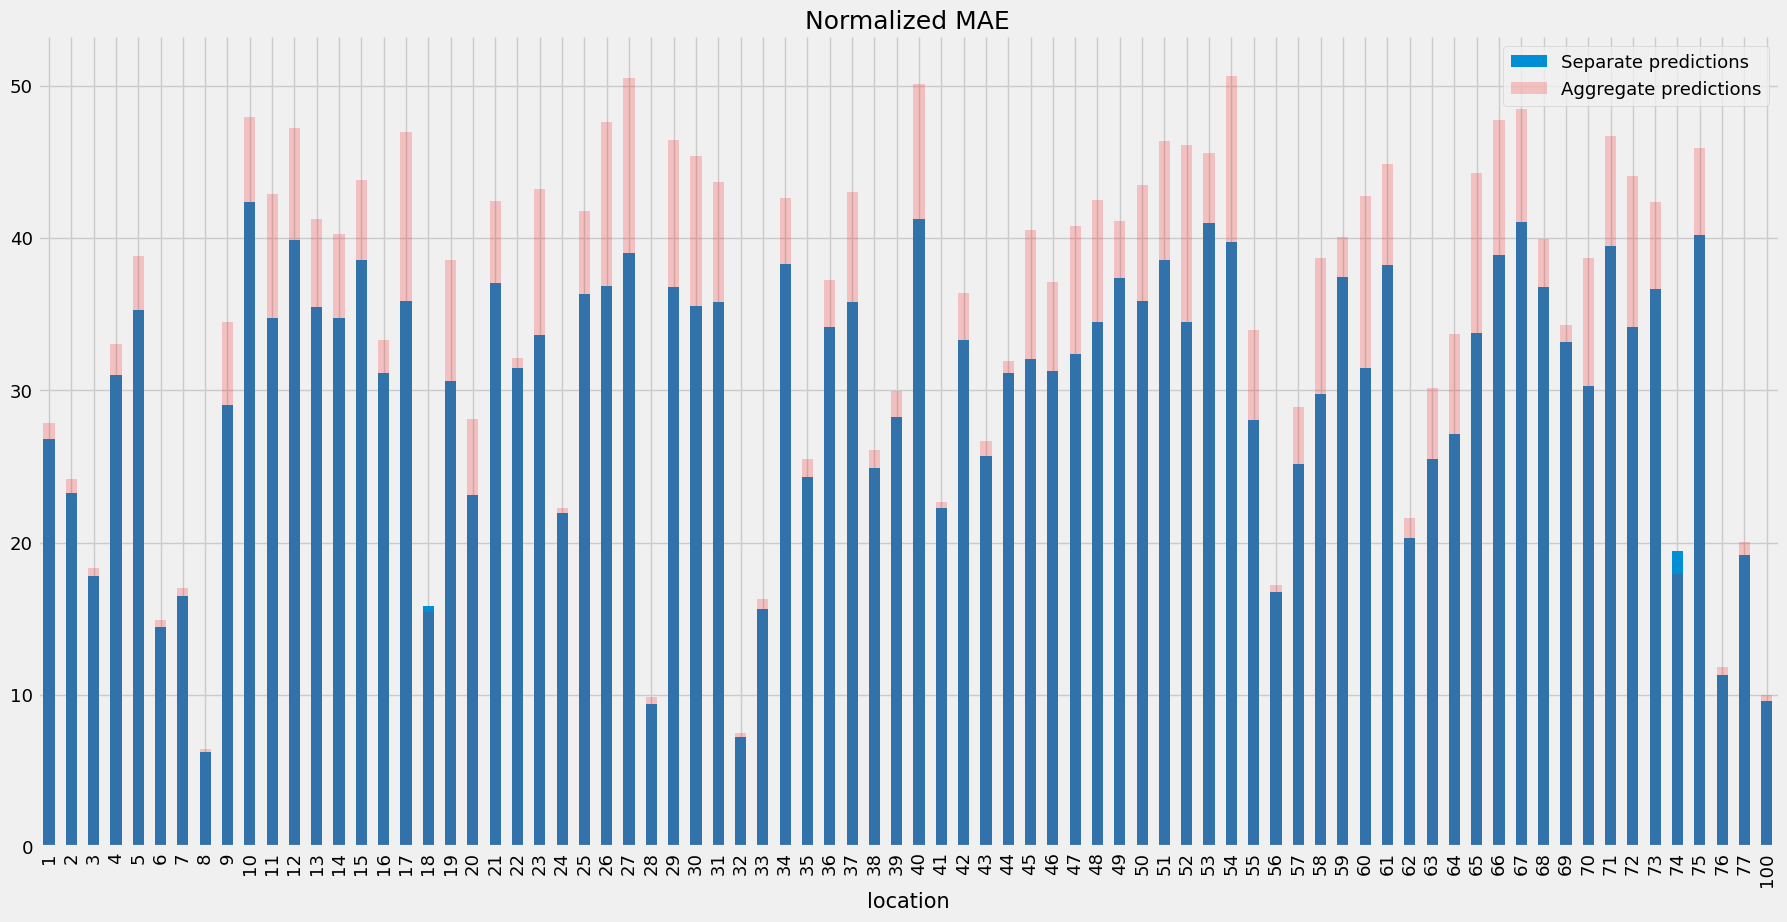

In [330]:
prediction_stats["normalized_preds_aggregate"].plot(kind="bar", title="Normalized MAE")
prediction_stats["normalized_preds"].plot(kind="bar", figsize=(20, 10), alpha=0.2, color="red")

plt.legend(["Separate predictions", "Aggregate predictions"]);

Plots for normalized and regular MAE:

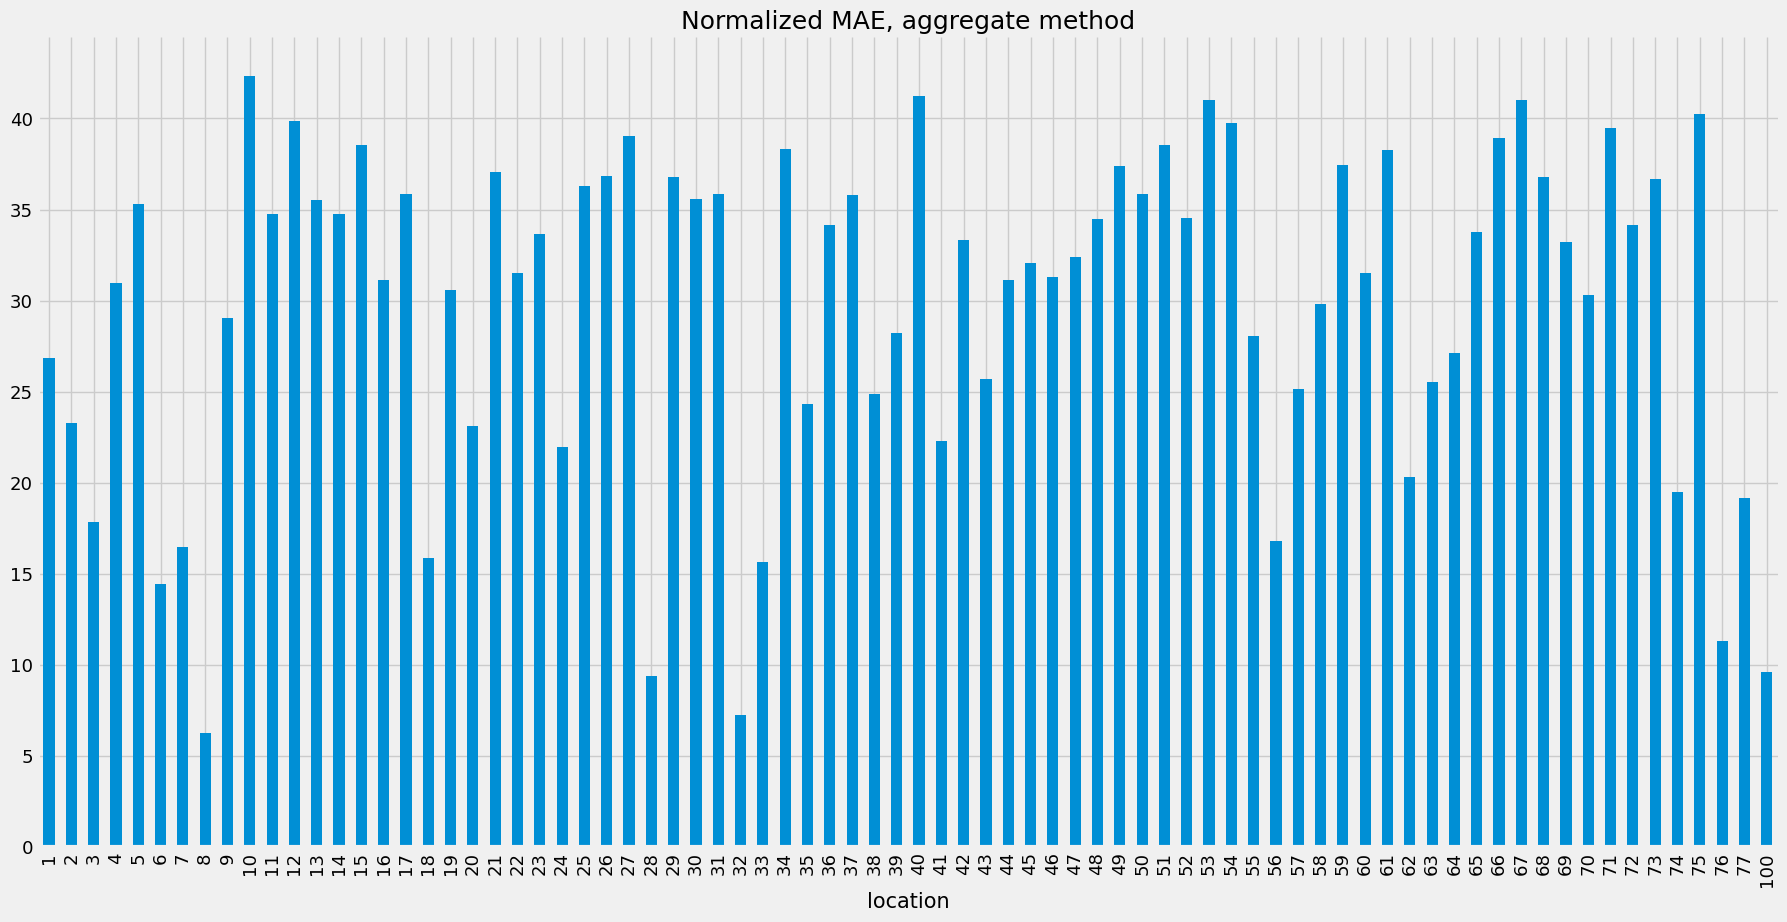

In [331]:
prediction_stats["normalized_preds_aggregate"].plot(
    kind="bar", figsize=(20, 10), title="Normalized MAE, aggregate method"
);

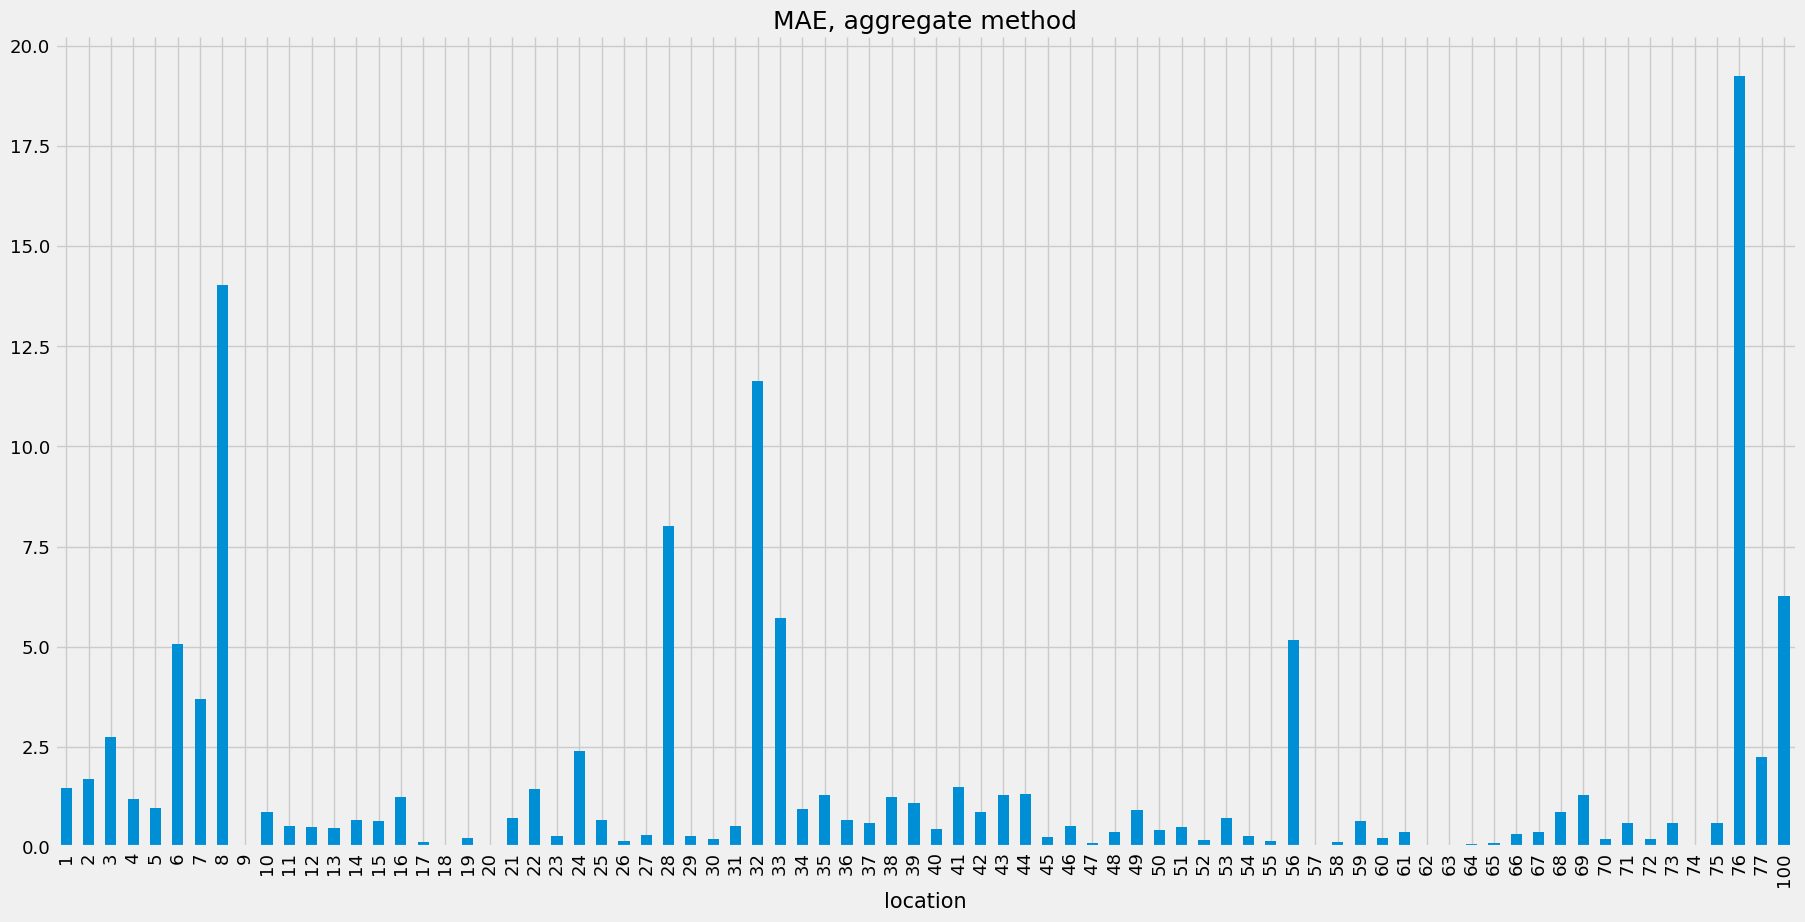

In [332]:
prediction_stats["preds_aggregate"].plot(kind="bar", figsize=(20, 10), title="MAE, aggregate method");

The normalized MAE metric is better for the locations with more trips (e.g. 8, 32) which means that the resulting model gets overall better predictions for these community areas. The MAE metric is at the same time higher for these regions.

### Trying to get better predictions for one of "bad" regions

The bad regions are the ones with high normalized MAE. Such regions have a low number of trips. Prediction of trips count using median values for hour and day of week, or usin only a small subset of features may provide better results for such regions. Below is an example for community area #10.

In [232]:
REGION = 10

In [233]:
for_bad_region = agg_preds[agg_preds["location"] == REGION]

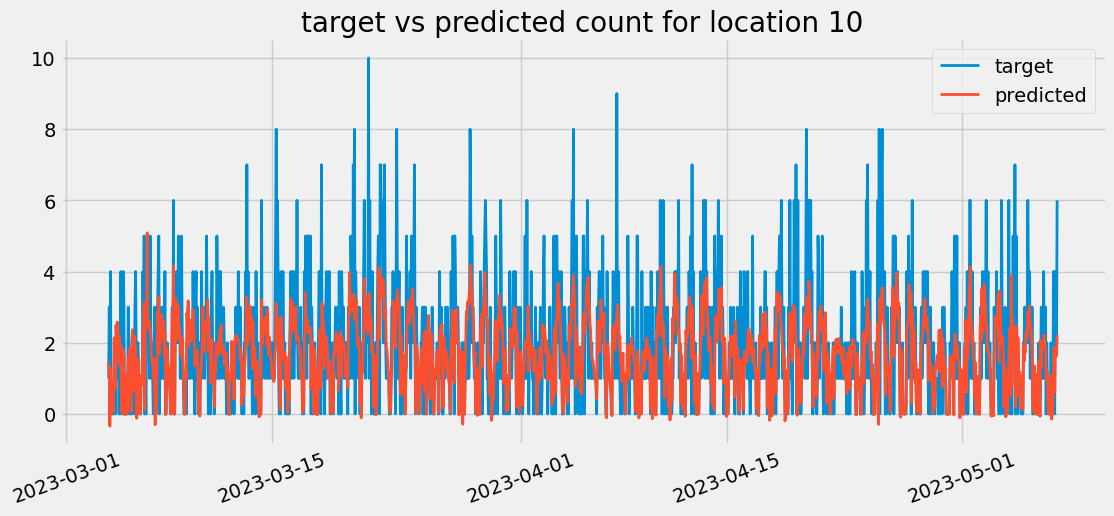

In [234]:
plt.figure(figsize=(12, 5))
plt.plot(for_bad_region["y_valid"][500:], label="target")
plt.plot(for_bad_region["predictions"][500:], label="predicted")
plt.xticks(rotation=20)
plt.title(f"target vs predicted count for location {REGION}")
plt.legend()
plt.show()

The figure for this location shows bad prediction quality.

#### Using less features

In [235]:
X_train_bad_region = X_train[X_train["location"] == REGION][["hour", "dayofweek"]]
y_train_bad_region = y_train[X_train["location"] == REGION]

In [236]:
X_valid_bad_region = X_valid[X_valid["location"] == REGION][["hour", "dayofweek"]]
y_valid_bad_region = y_valid[X_valid["location"] == REGION]

In [237]:
gbm_params_dummy = {
    "learning_rate": 0.1,  # has no impact
    "max_bin": 255,
    "n_estimators": 1000,  # leaving only best params to speed up the notebook :)
    "num_leaves": 400,
    "max_depth": 20,
}

In [238]:
gbm = lgb.LGBMRegressor(application="regression", metric="mae", **gbm_params_dummy)

In [239]:
gbm.fit(X_train_bad_region, y_train_bad_region)
preds_bad_region = gbm.predict(X_valid_bad_region)
mean_absolute_error(y_valid_bad_region, preds_bad_region)

1.0960471574076571

Using less features makes MAE slightly worse.

#### Using median

In [240]:
X_valid_bad_region = X_valid[X_valid["location"] == REGION]
y_valid_bad_region = y_valid[X_valid["location"] == REGION]

In [241]:
X_train_bad_region = X_train[X_train["location"] == REGION]
y_train_bad_region = y_train[X_train["location"] == REGION]

In [242]:
def predict_median(row):
    return preds_dow_hour[row["dayofweek"], row["hour"]]


preds_dow_hour = X_train_bad_region.join(y_train_bad_region).groupby(["dayofweek", "hour"])["count"].median()
mean_absolute_error(y_valid_bad_region, X_valid_bad_region.apply(predict_median, axis=1))

1.0823185582075012

#### Using regular approach

In [243]:
gbm = lgb.LGBMRegressor(application="regression", metric="mae", **gbm_params_dummy)

In [244]:
gbm.fit(X_train_bad_region, y_train_bad_region)
preds_bad_region = gbm.predict(X_valid_bad_region)
mean_absolute_error(y_valid_bad_region, abs(preds_bad_region))

1.0439180423793453

In [245]:
pr = list(map(lambda x: x if x >= 0 else 0, preds_bad_region))

In [246]:
mean_absolute_error(y_valid_bad_region, pr)

1.0430915421307352

MAE for this region using the regular boosting approach is 1.04.

Using median by day of week and hour provides worse MAE than regular boosting approach. Therefore, the best way is to use the regular boosting.

## Conclusion

An ensemble of LGBM regressor and CatBoost regressor is proposed as a method of prediction of taxi trips count for the next hour for Chicago taxi trips dataset. Two approaches were compared: using 1 model for all predictions, using a separate model for each community area, with first providing significantly better reults. Resulting MAE for predictions with the better approach is 1.59.